In [1]:
import docx
import os

import re
import pandas as pd
import numpy as np

# nltk
from nltk import tokenize

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Plotting tools
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
plt.style.use('seaborn')
# plt.style.use('grayscale')
%matplotlib inline

In [2]:
novel = []

for filename in os.listdir('text'):
    if filename == 'istanbul hatirasi ingilizce.docx':
        continue
    try:
        matches = re.search(r'([0-9]*)_([a-z]*)_', filename)
        position = int(matches[1])
        period = matches[2].replace('distant', 'Ancient History')\
                           .replace('recent', 'Modern History')\
                           .replace('current', 'Present Day')\
                           .replace('detectivestory', 'Detective Story')
        doc = docx.Document('text/{}'.format(filename))
        text = '\n\n'.join(paragraph.text for paragraph in doc.paragraphs)
        novel.append([position, period, text])
    except TypeError:
        print(filename)

novel = sorted(novel, key=lambda x: x[0])

In [3]:
analyzer = SentimentIntensityAnalyzer()

In [4]:
# Take average sentiment of each sentence in a section

# for section in novel:
#     sentences = tokenize.sent_tokenize(section[2])
#     sentiments = {'compound': 0.0, 'neg': 0.0, 'neu': 0.0, 'pos': 0.0}

#     for sentence in sentences:
#         vs = analyzer.polarity_scores(sentence)
#         sentiments['compound'] += vs['compound']
#         sentiments['neg'] += vs['neg']
#         sentiments['neu'] += vs['neu']
#         sentiments['pos'] += vs['pos']

#     sentiments['compound'] = sentiments['compound'] / len(sentences)
#     sentiments['neg'] = sentiments['neg'] / len(sentences)
#     sentiments['neu'] = sentiments['neu'] / len(sentences)
#     sentiments['pos'] = sentiments['pos'] / len(sentences)
#     section.append(len(sentences))
#     section.append(sentiments)

In [5]:
# Take average sentiment of n most extreme sentences in a section

for section in novel:
    sentences = tokenize.sent_tokenize(section[2])
    sentiments = {'compound': 0.0, 'neg': 0.0, 'neu': 0.0, 'pos': 0.0}
    compound = []
    neg = []
    neu = []
    pos = []

    for sentence in sentences:
        vs = analyzer.polarity_scores(sentence)
        compound.append((vs['compound'], sentence))
        sentiments['neg'] += vs['neg']
        sentiments['neu'] += vs['neu']
        sentiments['pos'] += vs['pos']
        
    compound = sorted(compound, reverse=True, key=lambda x: abs(x[0]))[:10]  # n most extreme sentences
    
    for sentence in [element[1] for element in compound]:
        vs = analyzer.polarity_scores(sentence)
        sentiments['compound'] += vs['compound']

    sentiments['compound'] = sentiments['compound'] / len(compound)
    sentiments['neg'] = sentiments['neg'] / len(sentences)
    sentiments['neu'] = sentiments['neu'] / len(sentences)
    sentiments['pos'] = sentiments['pos'] / len(sentences)
    section.append(len(sentences))
    section.append(sentiments)

In [6]:
df = pd.DataFrame({'section': [section[0] for section in novel],
                   'period': [section[1] for section in novel],
                   'text': [section[2] for section in novel],
                   'sentence_count': [section[3] for section in novel],
                   'compound': [section[4]['compound'] for section in novel],
                   'pos': [section[4]['pos'] for section in novel],
                   'neg': [section[4]['neg'] for section in novel],
                   'neu': [section[4]['neu'] for section in novel]})

In [7]:
df.head()

,section,period,text,sentence_count,compound,pos,neg,neu
0,1,Ancient History,Byzantium\n\nKing Byzas’ Fabled City\n\n\n\nD\...,55,0.04070,0.090073,0.061400,0.848527
1,2,Detective Story,The Crescent and the Star\n\nThe victim’s eyes...,8,-0.12115,0.009125,0.061125,0.929750
2,3,Present Day,"Two battered old ferries, those long-suffering...",2,0.58420,0.140500,0.000000,0.859500
3,4,Modern History,"I was taken back to the old days, the good old...",1,0.68580,0.170000,0.058000,0.772000
4,5,Detective Story,I suddenly felt someone’s eyes on me. Lifting ...,43,-0.18296,0.039953,0.075581,0.884465


In [8]:
df.describe()

,section,sentence_count,compound,pos,neg,neu
count,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000
mean,154.500000,36.863636,0.070684,0.075490,0.050623,0.873884
std,89.056162,88.643749,0.295873,0.050890,0.042271,0.063892
min,1.000000,1.000000,-0.890370,0.000000,0.000000,0.667000
25%,77.750000,3.000000,-0.079365,0.043923,0.016458,0.835789
50%,154.500000,7.500000,0.046785,0.068167,0.048696,0.870278
75%,231.250000,31.000000,0.232272,0.097921,0.077300,0.912536
max,308.000000,816.000000,0.907290,0.299667,0.292500,1.000000


In [9]:
chapter_breaks = []
sentence_count = 0
for sentence in tokenize.sent_tokenize((' ').join([entry[2] for entry in novel])):
    if '\n\n\n\n' in sentence:
        chapter_breaks.append(sentence_count)
    sentence_count += 1

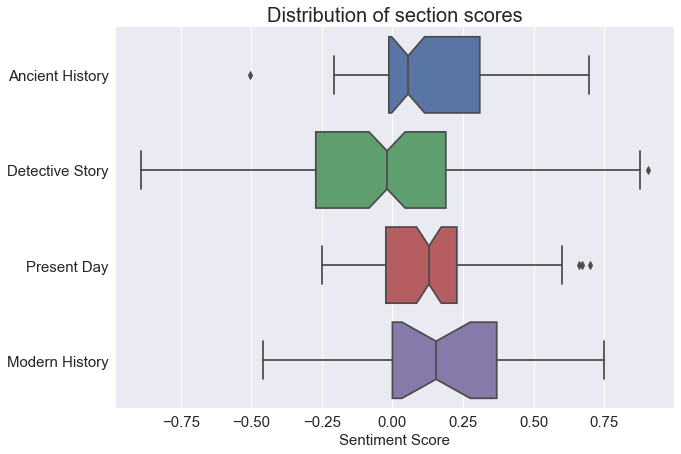

In [10]:
plt.figure(figsize=(10, 7))
sns.boxplot(x='compound', y='period', data=df, notch=True)
plt.xlabel('Sentiment Score', fontsize=15)
plt.ylabel('')
plt.title('Distribution of section scores', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig(boxplot.jpg, dpi=300)
plt.show()

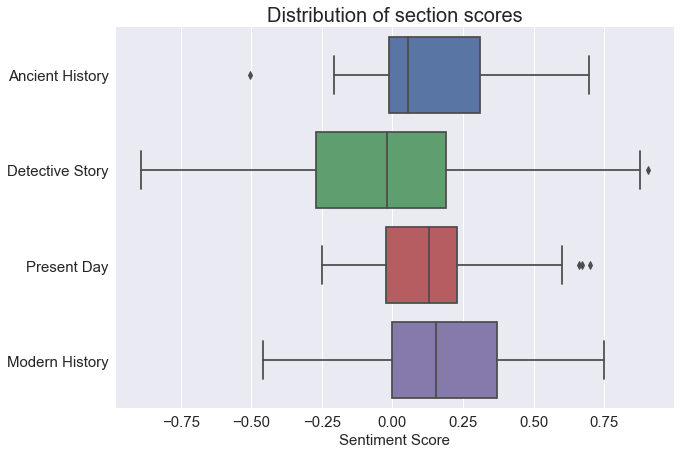

In [11]:
plt.figure(figsize=(10, 7))
sns.boxplot(x='compound', y='period', data=df, notch=False)
plt.xlabel('Sentiment Score', fontsize=15)
plt.ylabel('')
plt.title('Distribution of section scores', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig(boxplot.jpg, dpi=300)
plt.show()

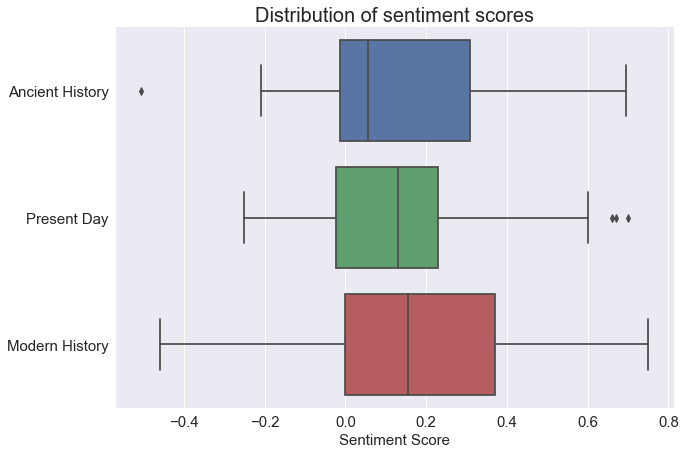

In [12]:
plt.figure(figsize=(10, 7))
sns.boxplot(x='compound', y='period', data=df[df['period'].isin(['Ancient History', 'Modern History', 'Present Day'])], notch=False)
plt.xlabel('Sentiment Score', fontsize=15)
plt.ylabel('')
plt.title('Distribution of sentiment scores', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig(boxplot.jpg, dpi=300)
plt.show()

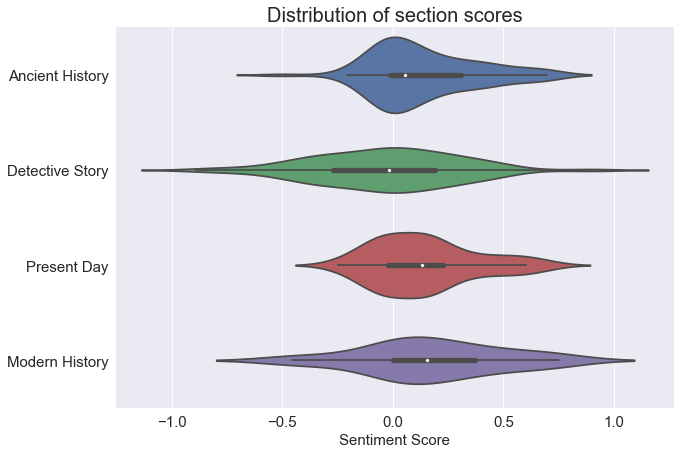

In [13]:
plt.figure(figsize=(10, 7))
sns.violinplot(x='compound', y='period', data=df, notch=True)
plt.xlabel('Sentiment Score', fontsize=15)
plt.ylabel('')
plt.title('Distribution of section scores', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [14]:
book_indices = {}
idx = 0
for section in novel:
    start = idx
    idx += section[3]
    book_indices[section[0]] = (start, idx, section[1])

In [15]:
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

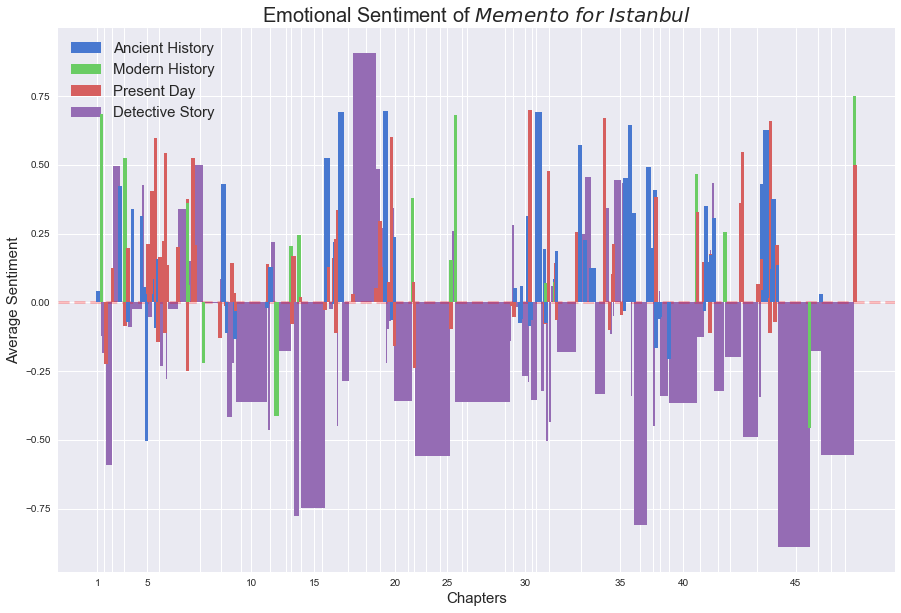

In [16]:
length = sum([section[3] for section in novel])
x = np.linspace(0, length - 1, num=length)
y = [item for sublist in [[section[4]['compound']] * section[3] for section in novel] for item in sublist]

plt.figure(figsize=(15, 10))

for section in book_indices:
    if book_indices[section][2] == 'Ancient History':
        plt.bar(x[book_indices[section][0]: book_indices[section][1]],
                 y[book_indices[section][0]: book_indices[section][1]],
                 label=book_indices[section][2], color='#4878d0', width=50, zorder=10)
    elif book_indices[section][2] == 'Modern History':
        plt.bar(x[book_indices[section][0]: book_indices[section][1]],
                 y[book_indices[section][0]: book_indices[section][1]],
                 label=book_indices[section][2], color='#6acc64', width=50, zorder=10)
    elif book_indices[section][2] == 'Present Day':
        plt.bar(x[book_indices[section][0]: book_indices[section][1]],
                 y[book_indices[section][0]: book_indices[section][1]],
                 label=book_indices[section][2], color='#d65f5f', width=50, zorder=10)
    elif book_indices[section][2] == 'Detective Story':
        plt.bar(x[book_indices[section][0]: book_indices[section][1]],
                 y[book_indices[section][0]: book_indices[section][1]],
                 label=book_indices[section][2], color='#956cb4', width=1, zorder=1)
plt.axhline(y=0, xmin=0, xmax=length, alpha=.25, color='r', linestyle='--', linewidth=3)

handles, labels = plt.gca().get_legend_handles_labels()
handles = [handles[0], handles[3], handles[2], handles[1]]
labels = [labels[0], labels[3], labels[2], labels[1]]
plt.legend(handles, labels, loc='upper left', fontsize=15)
plt.title('Emotional Sentiment of $Memento\ for\ Istanbul$', fontsize=20)
plt.xlabel('Chapters', fontsize=15)
plt.xticks(ticks=chapter_breaks, labels=[element + 1 if element == 0 or (element + 1) % 5 == 0 else '' for element in range(len(chapter_breaks))])
plt.ylabel('Average Sentiment', fontsize=15)
plt.show()

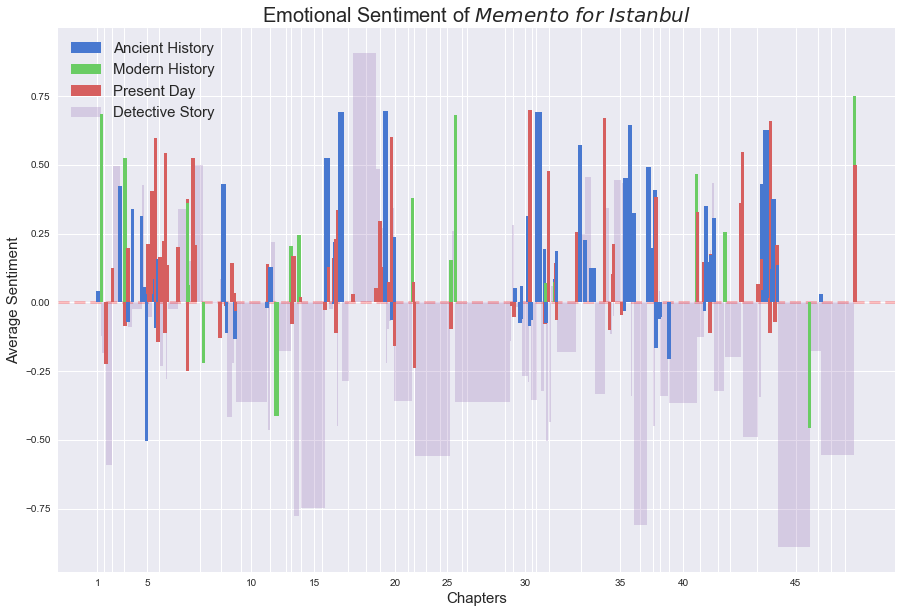

In [17]:
length = sum([section[3] for section in novel])
x = np.linspace(0, length - 1, num=length)
y = [item for sublist in [[section[4]['compound']] * section[3] for section in novel] for item in sublist]

plt.figure(figsize=(15, 10))

for section in book_indices:
    if book_indices[section][2] == 'Ancient History':
        plt.bar(x[book_indices[section][0]: book_indices[section][1]],
                 y[book_indices[section][0]: book_indices[section][1]],
                 label=book_indices[section][2], color='#4878d0', width=50, zorder=10)
    elif book_indices[section][2] == 'Modern History':
        plt.bar(x[book_indices[section][0]: book_indices[section][1]],
                 y[book_indices[section][0]: book_indices[section][1]],
                 label=book_indices[section][2], color='#6acc64', width=50, zorder=10)
    elif book_indices[section][2] == 'Present Day':
        plt.bar(x[book_indices[section][0]: book_indices[section][1]],
                 y[book_indices[section][0]: book_indices[section][1]],
                 label=book_indices[section][2], color='#d65f5f', width=50, zorder=10)
    elif book_indices[section][2] == 'Detective Story':
        plt.bar(x[book_indices[section][0]: book_indices[section][1]],
                 y[book_indices[section][0]: book_indices[section][1]],
                 label=book_indices[section][2], color='#956cb4', width=1, zorder=1, alpha=.25)
plt.axhline(y=0, xmin=0, xmax=length, alpha=.25, color='r', linestyle='--', linewidth=3)

handles, labels = plt.gca().get_legend_handles_labels()
handles = [handles[0], handles[3], handles[2], handles[1]]
labels = [labels[0], labels[3], labels[2], labels[1]]
plt.legend(handles, labels, loc='upper left', fontsize=15)
plt.title('Emotional Sentiment of $Memento\ for\ Istanbul$', fontsize=20)
plt.xlabel('Chapters', fontsize=15)
plt.xticks(ticks=chapter_breaks, labels=[element + 1 if element == 0 or (element + 1) % 5 == 0 else '' for element in range(len(chapter_breaks))])
plt.ylabel('Average Sentiment', fontsize=15)
plt.show()

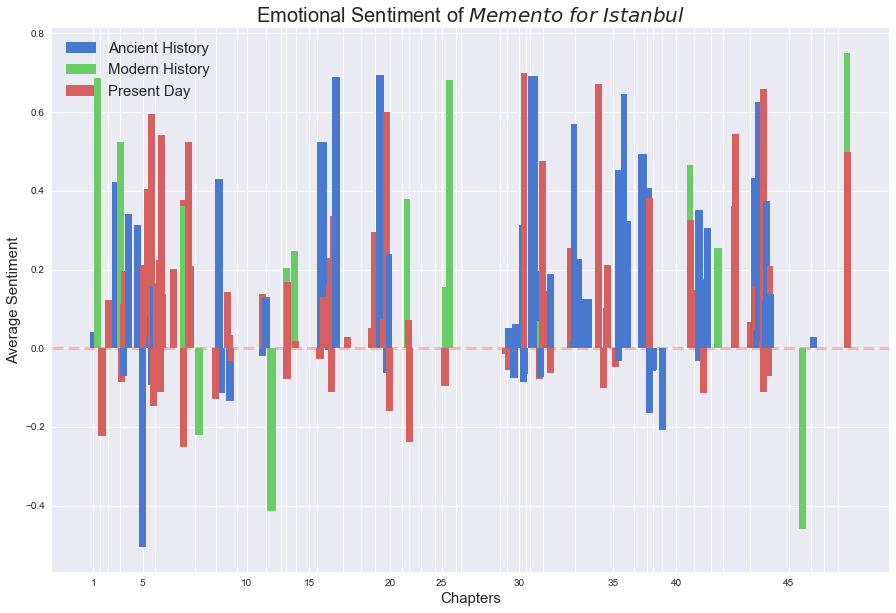

In [18]:
length = sum([section[3] for section in novel])
x = np.linspace(0, length - 1, num=length)
y = [item for sublist in [[section[4]['compound']] * section[3] for section in novel] for item in sublist]

plt.figure(figsize=(15, 10))

for section in book_indices:
    if book_indices[section][2] == 'Ancient History':
        plt.bar(x[book_indices[section][0]: book_indices[section][1]],
                 y[book_indices[section][0]: book_indices[section][1]],
                 label=book_indices[section][2], color='#4878d0', width=100, zorder=10)
    elif book_indices[section][2] == 'Modern History':
        plt.bar(x[book_indices[section][0]: book_indices[section][1]],
                 y[book_indices[section][0]: book_indices[section][1]],
                 label=book_indices[section][2], color='#6acc64', width=100, zorder=10)
    elif book_indices[section][2] == 'Present Day':
        plt.bar(x[book_indices[section][0]: book_indices[section][1]],
                 y[book_indices[section][0]: book_indices[section][1]],
                 label=book_indices[section][2], color='#d65f5f', width=100, zorder=10)
plt.axhline(y=0, xmin=0, xmax=length, alpha=.25, color='r', linestyle='--', linewidth=3)

handles, labels = plt.gca().get_legend_handles_labels()
handles = [handles[0], handles[2], handles[1]]
labels = [labels[0], labels[2], labels[1]]
plt.legend(handles, labels, loc='upper left', fontsize=15)
plt.title('Emotional Sentiment of $Memento\ for\ Istanbul$', fontsize=20)
plt.xlabel('Chapters', fontsize=15)
plt.xticks(ticks=chapter_breaks, labels=[element + 1 if element == 0 or (element + 1) % 5 == 0 else '' for element in range(len(chapter_breaks))])
plt.ylabel('Average Sentiment', fontsize=15)
plt.show()

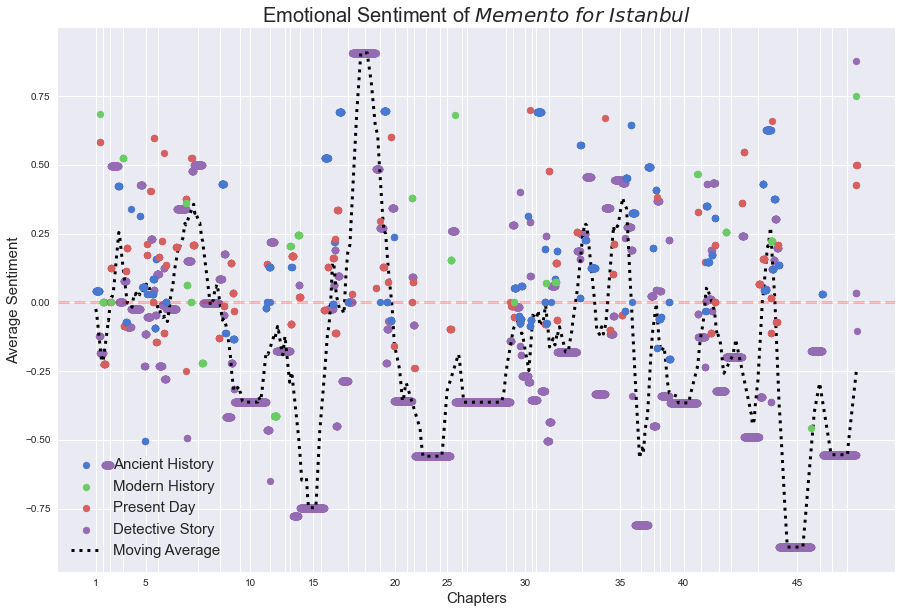

In [19]:
length = sum([section[3] for section in novel])
x = np.linspace(0, length - 1, num=length)
y = [item for sublist in [[section[4]['compound']] * section[3] for section in novel] for item in sublist]

legend_items = {'Ancient History': False, 'Modern History': False, 'Present Day': False, 'Detective Story': False}

plt.figure(figsize=(15, 10))

# for chapter in chapter_breaks:
#     plt.axvline(x=chapter, ymin=0.01, ymax=.125, alpha=.5, color='k', linestyle='-', linewidth=1, zorder=1)

for section in book_indices:
    if legend_items[book_indices[section][2]]:
        label = ''
    else:
        label = book_indices[section][2]
        legend_items[book_indices[section][2]] = True

    if book_indices[section][2] == 'Ancient History':
        color = '#4878d0'
        zorder=10
    elif book_indices[section][2] == 'Modern History':
        color = '#6acc64'
        zorder=10
    elif book_indices[section][2] == 'Present Day':
        color = '#d65f5f'
        zorder=10
    elif book_indices[section][2] == 'Detective Story':
        color = '#956cb4'
        zorder=1
    plt.scatter(x[book_indices[section][0]: book_indices[section][1]],
             y[book_indices[section][0]: book_indices[section][1]],
             label=label, color=color, zorder=zorder)
plt.plot(movingaverage(y, 250), color='k', linewidth=3, linestyle=':', label = 'Moving Average')
plt.axhline(y=0, xmin=0, xmax=length, alpha=.25, color='r', linestyle='--', linewidth=3)

handles, labels = plt.gca().get_legend_handles_labels()
handles = [handles[1], handles[4], handles[3], handles[2], handles[0]]
labels = [labels[1], labels[4], labels[3], labels[2], labels[0]]
plt.legend(handles, labels, loc='lower left', fontsize=15)
plt.title('Emotional Sentiment of $Memento\ for\ Istanbul$', fontsize=20)
plt.xlabel('Chapters', fontsize=15)
plt.xticks(ticks=chapter_breaks, labels=[element + 1 if element == 0 or (element + 1) % 5 == 0 else '' for element in range(len(chapter_breaks))])
plt.ylabel('Average Sentiment', fontsize=15)
plt.show()

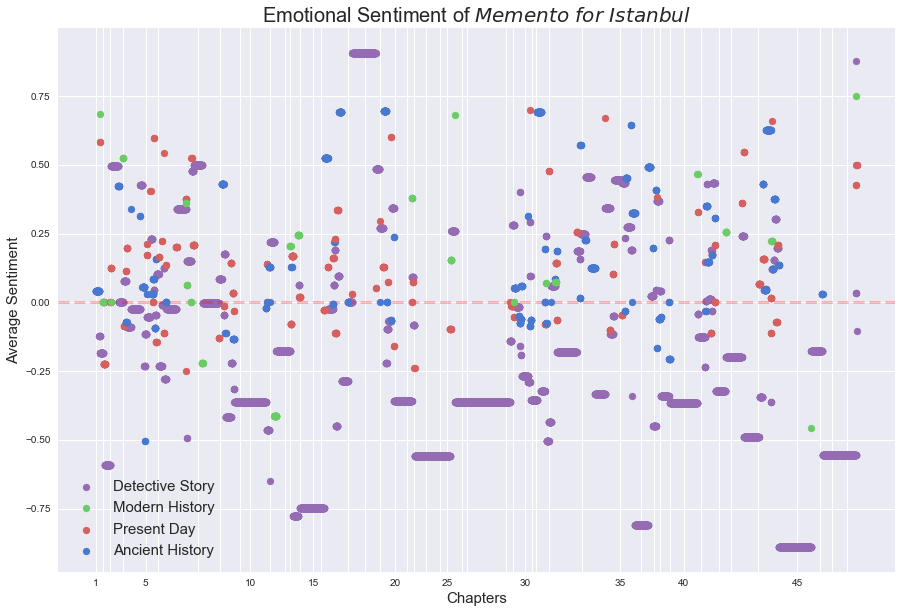

In [20]:
length = sum([section[3] for section in novel])
x = np.linspace(0, length - 1, num=length)
y = [item for sublist in [[section[4]['compound']] * section[3] for section in novel] for item in sublist]

legend_items = {'Ancient History': False, 'Modern History': False, 'Present Day': False, 'Detective Story': False}

plt.figure(figsize=(15, 10))

# for chapter in chapter_breaks:
#     plt.axvline(x=chapter, ymin=0.01, ymax=.125, alpha=.5, color='k', linestyle='-', linewidth=1, zorder=1)

for section in book_indices:
    if legend_items[book_indices[section][2]]:
        label = ''
    else:
        label = book_indices[section][2]
        legend_items[book_indices[section][2]] = True

    if book_indices[section][2] == 'Ancient History':
        color = '#4878d0'
        zorder=10
    elif book_indices[section][2] == 'Modern History':
        color = '#6acc64'
        zorder=10
    elif book_indices[section][2] == 'Present Day':
        color = '#d65f5f'
        zorder=10
    elif book_indices[section][2] == 'Detective Story':
        color = '#956cb4'
        zorder=1
    plt.scatter(x[book_indices[section][0]: book_indices[section][1]],
             y[book_indices[section][0]: book_indices[section][1]],
             label=label, color=color, zorder=zorder)
# plt.plot(movingaverage(y, 250), color='k', linewidth=3, linestyle=':', label = 'Moving Average')
plt.axhline(y=0, xmin=0, xmax=length, alpha=.25, color='r', linestyle='--', linewidth=3)

handles, labels = plt.gca().get_legend_handles_labels()
handles = [handles[1], handles[3], handles[2], handles[0]]
labels = [labels[1], labels[3], labels[2], labels[0]]
plt.legend(handles, labels, loc='lower left', fontsize=15)
plt.title('Emotional Sentiment of $Memento\ for\ Istanbul$', fontsize=20)
plt.xlabel('Chapters', fontsize=15)
plt.xticks(ticks=chapter_breaks, labels=[element + 1 if element == 0 or (element + 1) % 5 == 0 else '' for element in range(len(chapter_breaks))])
plt.ylabel('Average Sentiment', fontsize=15)
plt.show()

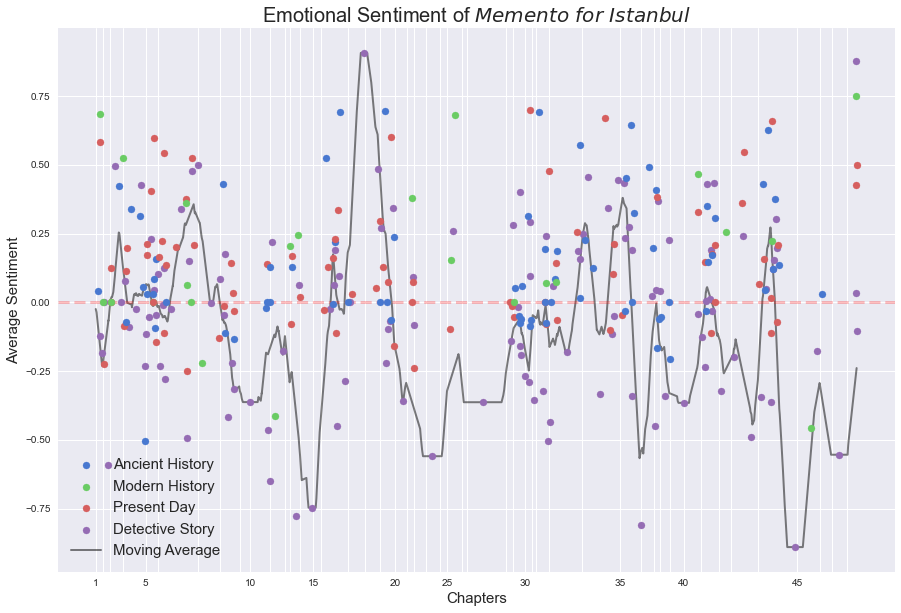

In [21]:
length = sum([section[3] for section in novel])
x = np.linspace(0, length - 1, num=length)
x = np.linspace(0, length, num=length+1)
y = [item for sublist in [[section[4]['compound']] * section[3] for section in novel] for item in sublist]

plt.figure(figsize=(15, 10))

for section in book_indices:
    if book_indices[section][2] == 'Ancient History':
        plt.scatter((x[book_indices[section][0]] + x[book_indices[section][1]]) / 2,
                 y[book_indices[section][0]],
                 label=book_indices[section][2], color='#4878d0', zorder=10)
    elif book_indices[section][2] == 'Modern History':
        plt.scatter((x[book_indices[section][0]] + x[book_indices[section][1]]) / 2,
                 y[book_indices[section][0]],
                 label=book_indices[section][2], color='#6acc64', zorder=10)
    elif book_indices[section][2] == 'Present Day':
        plt.scatter((x[book_indices[section][0]] + x[book_indices[section][1]]) / 2,
                 y[book_indices[section][0]],
                 label=book_indices[section][2], color='#d65f5f', zorder=10)
    elif book_indices[section][2] == 'Detective Story':
        plt.scatter((x[book_indices[section][0]] + x[book_indices[section][1]]) / 2,
                 y[book_indices[section][0]],
                 label=book_indices[section][2], color='#956cb4', zorder=5)
plt.plot(movingaverage(y, 250), color='k', alpha=.5, linewidth=2, linestyle='-', label = 'Moving Average', zorder=1)
plt.axhline(y=0, xmin=0, xmax=length, alpha=.25, color='r', linestyle='--', linewidth=3)

handles, labels = plt.gca().get_legend_handles_labels()
handles = [handles[1], handles[4], handles[3], handles[2], handles[0]]
labels = [labels[1], labels[4], labels[3], labels[2], labels[0]]
plt.legend(handles, labels, loc='lower left', fontsize=15)
plt.title('Emotional Sentiment of $Memento\ for\ Istanbul$', fontsize=20)
plt.xlabel('Chapters', fontsize=15)
plt.xticks(ticks=chapter_breaks, labels=[element + 1 if element == 0 or (element + 1) % 5 == 0 else '' for element in range(len(chapter_breaks))])
plt.ylabel('Average Sentiment', fontsize=15)
plt.show()

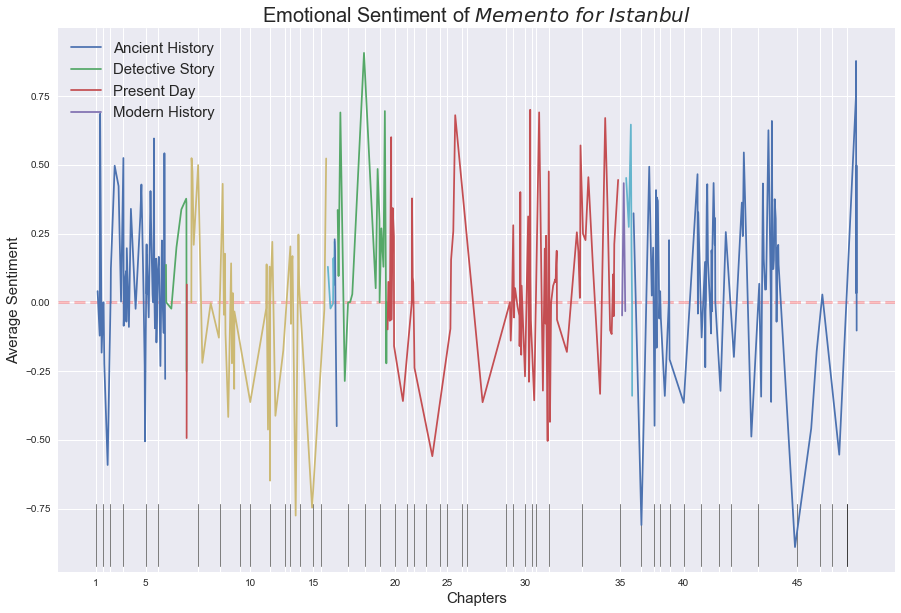

In [22]:
length = sum([section[3] for section in novel])

x = []
previous = 0
for idx, element in enumerate([section[3] for section in novel]):
    if idx == 0:
        x.append(element / 2)
    else:
        x.append(previous + element / 2)
    previous += element
    
y = [item for sublist in [[section[4]['compound']] for section in novel] for item in sublist]

legend_items = {'Ancient History': False, 'Modern History': False, 'Present Day': False, 'Detective Story': False}

plt.figure(figsize=(15, 10))

for chapter in chapter_breaks:
    plt.axvline(x=chapter, ymin=0.01, ymax=.125, alpha=.5, color='k', linestyle='-', linewidth=1, zorder=1)

for section in book_indices:
    if legend_items[book_indices[section][2]]:
        label = ''
    else:
        label = book_indices[section][2]
        legend_items[book_indices[section][2]] = True
    plt.plot(x[book_indices[section][0]: book_indices[section][1]],
             y[book_indices[section][0]: book_indices[section][1]],
             label=label, zorder=10)
# plt.plot(movingaverage(y, 10), color='k', linewidth=3, linestyle=':', label = 'Moving Average')
plt.axhline(y=0, xmin=0, xmax=length, alpha=.25, color='r', linestyle='--', linewidth=3)
plt.legend(loc='upper left', fontsize=15)
plt.title('Emotional Sentiment of $Memento\ for\ Istanbul$', fontsize=20)
plt.xlabel('Chapters', fontsize=15)
plt.xticks(ticks=chapter_breaks, labels=[chapter + 1 if chapter == 0 or (chapter + 1) % 5 == 0 else '' for chapter in range(len(chapter_breaks))])
plt.ylabel('Average Sentiment', fontsize=15)
plt.show()

In [23]:
import pandas as pd
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer


def text_emotion(df, column):
    '''
    Takes a DataFrame and a specified column of text and adds 10 columns to the
    DataFrame for each of the 10 emotions in the NRC Emotion Lexicon, with each
    column containing the value of the text in that emotions
    INPUT: DataFrame, string
    OUTPUT: the original DataFrame with ten new columns
    '''

    new_df = df.copy()

    filepath = ('NRC-Sentiment-Emotion-Lexicons/'
                'NRC-Emotion-Lexicon-v0.92/'
                'NRC-Emotion-Lexicon-Wordlevel-v0.92.txt')
    emolex_df = pd.read_csv(filepath,
                            names=["word", "emotion", "association"],
                            sep='\t').dropna()
    emolex_words = emolex_df.pivot(index='word',
                                   columns='emotion',
                                   values='association').reset_index()
    emotions = emolex_words.columns.drop('word')
    emo_df = pd.DataFrame(0, index=df.index, columns=emotions)

    stemmer = SnowballStemmer("english")
    
    for i, row in new_df.iterrows():
        document = word_tokenize(new_df.loc[i][column])
        for word in document:
            word = stemmer.stem(word.lower())
            emo_score = emolex_words[emolex_words.word == word]
            if not emo_score.empty:
                for emotion in list(emotions):
                    emo_df.at[i, emotion] += emo_score[emotion]

    new_df = pd.concat([new_df, emo_df], axis=1)

    return new_df

In [24]:
df.head()

,section,period,text,sentence_count,compound,pos,neg,neu
0,1,Ancient History,Byzantium\n\nKing Byzas’ Fabled City\n\n\n\nD\...,55,0.04070,0.090073,0.061400,0.848527
1,2,Detective Story,The Crescent and the Star\n\nThe victim’s eyes...,8,-0.12115,0.009125,0.061125,0.929750
2,3,Present Day,"Two battered old ferries, those long-suffering...",2,0.58420,0.140500,0.000000,0.859500
3,4,Modern History,"I was taken back to the old days, the good old...",1,0.68580,0.170000,0.058000,0.772000
4,5,Detective Story,I suddenly felt someone’s eyes on me. Lifting ...,43,-0.18296,0.039953,0.075581,0.884465


In [25]:
from collections import Counter

def text_emotion_with_counter(df, column):
    '''
    Takes a DataFrame and a specified column of text and adds 10 columns to the
    DataFrame for each of the 10 emotions in the NRC Emotion Lexicon, with each
    column containing the value of the text in that emotions
    INPUT: DataFrame, string
    OUTPUT: the original DataFrame with ten new columns
    '''

    new_df = df.copy()

    filepath = ('NRC-Sentiment-Emotion-Lexicons/'
                'NRC-Emotion-Lexicon-v0.92/'
                'NRC-Emotion-Lexicon-Wordlevel-v0.92.txt')
    emolex_df = pd.read_csv(filepath,
                            names=["word", "emotion", "association"],
                            sep='\t').dropna()
    emolex_words = emolex_df.pivot(index='word',
                                   columns='emotion',
                                   values='association').reset_index()
    emotions = emolex_words.columns.drop('word')
    emo_df = pd.DataFrame(0, index=df.index, columns=emotions)

    stemmer = SnowballStemmer("english")
    
    emotion_count = {}
    for emotion in emotions:
        emotion_count[emotion] = Counter()
    
    for i, row in new_df.iterrows():
        document = word_tokenize(new_df.loc[i][column])
        for word in document:
            word = stemmer.stem(word.lower())
            emo_score = emolex_words[emolex_words.word == word]
            if not emo_score.empty:
                for emotion in list(emotions):
                    emo_df.at[i, emotion] += emo_score[emotion]
                    if emo_score[emotion].values == 1:
                        emotion_count[emotion][word] += 1

    new_df = pd.concat([new_df, emo_df], axis=1)

    return new_df, emotion_count

In [26]:
# df = text_emotion(df, 'text')
df, emotion_count = text_emotion_with_counter(df, 'text')
df['word_count'] = df['text'].apply(tokenize.word_tokenize).apply(len)
emotions = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']
for emotion in emotions:
    df[emotion] = df[emotion] / df['word_count']

In [27]:
for emotion in emotions:
    print(emotion, emotion_count[emotion].most_common(10))

anger [('victim', 198), ('murder', 152), ('death', 85), ('lie', 71), ('stone', 69), ('tree', 46), ('lawyer', 43), ('fear', 42), ('gun', 40), ('hell', 37)]
anticipation [('time', 331), ('good', 163), ('thought', 163), ('start', 156), ('god', 133), ('happen', 115), ('wait', 111), ('long', 110), ('young', 88), ('death', 85)]
disgust [('murder', 152), ('death', 85), ('lie', 71), ('tree', 46), ('boy', 43), ('lawyer', 43), ('hell', 37), ('smell', 31), ('lose', 30), ('parrot', 25)]
fear [('sultan', 224), ('kill', 212), ('victim', 198), ('murder', 152), ('god', 133), ('death', 85), ('case', 84), ('watch', 80), ('doubt', 63), ('die', 60)]
joy [('found', 195), ('good', 163), ('love', 156), ('god', 133), ('friend', 131), ('smile', 117), ('kind', 111), ('young', 88), ('hope', 76), ('church', 72)]
negative [('kill', 212), ('victim', 198), ('murder', 152), ('wait', 111), ('death', 85), ('case', 84), ('quit', 75), ('lost', 74), ('lie', 71), ('stone', 69)]
positive [('don', 396), ('inspector', 201), (

In [28]:
total_emotion_count = Counter()
for emotion in emotions:
    total_emotion_count += emotion_count[emotion]

In [29]:
from functools import reduce
from operator import add
reduce(add, [emotion_count[emotion] for emotion in emotions]) == total_emotion_count

True

In [30]:
len(total_emotion_count)

1346

In [31]:
total_emotion_count.most_common(10)

[('murder', 912),
 ('good', 815),
 ('victim', 792),
 ('don', 792),
 ('god', 665),
 ('kill', 636),
 ('death', 595),
 ('found', 585),
 ('smile', 468),
 ('friend', 393)]

In [32]:
import nltk
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sentence = 'Again, human interaction needs to have resolutions. Your reps cannot BLAME the system and shrug off being able to help. Let alone blame the system and not know WHY the system makes indiscriminate decisions.'
tokenized_sentence = nltk.word_tokenize(sentence)

sid = SentimentIntensityAnalyzer()
pos_word_list=[]
neu_word_list=[]
neg_word_list=[]

for word in tokenized_sentence:
    if (sid.polarity_scores(word)['compound']) >= 0.1:
        pos_word_list.append(word)
    elif (sid.polarity_scores(word)['compound']) <= -0.1:
        neg_word_list.append(word)
    else:
        neu_word_list.append(word)                

print('Positive:',pos_word_list)        
print('Neutral:',neu_word_list)    
print('Negative:',neg_word_list) 
score = sid.polarity_scores(sentence)
print('\nScores:', score)

Positive: ['help']
Neutral: ['Again', ',', 'human', 'interaction', 'needs', 'to', 'have', 'resolutions', '.', 'Your', 'reps', 'can', 'not', 'the', 'system', 'and', 'shrug', 'off', 'being', 'able', 'to', '.', 'Let', 'the', 'system', 'and', 'not', 'know', 'WHY', 'the', 'system', 'makes', 'indiscriminate', 'decisions', '.']
Negative: ['BLAME', 'alone', 'blame']

Scores: {'neg': 0.111, 'neu': 0.756, 'pos': 0.133, 'compound': 0.2212}


In [33]:
import string

sentiment_count = {}
sid = SentimentIntensityAnalyzer()

for sentiment in ['positive', 'neutral', 'negative']:
    sentiment_count[sentiment] = Counter()

for i, row in df.iterrows():
    tokenized_sentence = nltk.word_tokenize(row['text'].translate(str.maketrans('', '', string.punctuation + '’' + '“' + '”')))
    
    for word in tokenized_sentence:
        if (sid.polarity_scores(word)['compound']) >= 0.1:
            sentiment_count['positive'][word] += 1
        elif (sid.polarity_scores(word)['compound']) <= -0.1:
            sentiment_count['negative'][word] += 1
        else:
            sentiment_count['neutral'][word] += 1

In [34]:
for sentiment in ['positive', 'neutral', 'negative']:
    print(sentiment, sentiment_count[sentiment].most_common(10))

positive [('like', 468), ('well', 164), ('good', 129), ('hand', 126), ('sure', 110), ('Well', 109), ('God', 101), ('kind', 96), ('help', 83), ('straight', 77)]
neutral [('the', 10673), ('to', 5167), ('and', 4218), ('I', 4111), ('of', 4105), ('was', 3472), ('a', 3367), ('in', 2597), ('he', 1582), ('you', 1555)]
negative [('no', 401), ('No', 131), ('victims', 122), ('killed', 114), ('killers', 102), ('Ill', 97), ('killer', 90), ('victim', 80), ('death', 76), ('lost', 72)]


In [35]:
sentiment_count = {}
sid = SentimentIntensityAnalyzer()
stemmer = SnowballStemmer("english")

for sentiment in ['positive', 'neutral', 'negative']:
    sentiment_count[sentiment] = Counter()

for i, row in df.iterrows():
    tokenized_sentence = nltk.word_tokenize(row['text'].translate(str.maketrans('', '', string.punctuation + '’' + '“' + '”')))
    stemmed_sentence = [stemmer.stem(word.lower()) for word in tokenized_sentence]
    
    for word in stemmed_sentence:
        if (sid.polarity_scores(word)['compound']) >= 0.1:
            sentiment_count['positive'][word] += 1
        elif (sid.polarity_scores(word)['compound']) <= -0.1:
            sentiment_count['negative'][word] += 1
        else:
            sentiment_count['neutral'][word] += 1

In [36]:
for sentiment in ['positive', 'neutral', 'negative']:
    print(sentiment, sentiment_count[sentiment].most_common(10))

positive [('like', 525), ('hand', 290), ('well', 276), ('good', 164), ('love', 156), ('friend', 138), ('god', 134), ('smile', 119), ('sure', 117), ('yes', 117)]
neutral [('the', 11822), ('to', 5238), ('and', 4584), ('of', 4208), ('i', 4111), ('a', 3551), ('was', 3539), ('in', 2731), ('it', 2533), ('he', 2424)]
negative [('no', 532), ('kill', 218), ('victim', 202), ('killer', 196), ('murder', 160), ('stop', 109), ('ill', 104), ('death', 92), ('miss', 86), ('poor', 80)]


In [37]:
df.head()

,section,period,text,sentence_count,compound,pos,neg,neu,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,word_count
0,1,Ancient History,Byzantium\n\nKing Byzas’ Fabled City\n\n\n\nD\...,55,0.04070,0.090073,0.061400,0.848527,0.017586,0.023981,0.007194,0.018385,0.015987,0.035971,0.068745,0.017586,0.007994,0.019984,1251
1,2,Detective Story,The Crescent and the Star\n\nThe victim’s eyes...,8,-0.12115,0.009125,0.061125,0.929750,0.021164,0.026455,0.010582,0.021164,0.005291,0.026455,0.037037,0.015873,0.010582,0.021164,189
2,3,Present Day,"Two battered old ferries, those long-suffering...",2,0.58420,0.140500,0.000000,0.859500,0.030303,0.030303,0.015152,0.015152,0.030303,0.015152,0.075758,0.015152,0.030303,0.045455,66
3,4,Modern History,"I was taken back to the old days, the good old...",1,0.68580,0.170000,0.058000,0.772000,0.000000,0.019231,0.000000,0.000000,0.038462,0.019231,0.038462,0.019231,0.019231,0.019231,52
4,5,Detective Story,I suddenly felt someone’s eyes on me. Lifting ...,43,-0.18296,0.039953,0.075581,0.884465,0.008761,0.012516,0.001252,0.015019,0.003755,0.030038,0.013767,0.013767,0.002503,0.008761,799


In [38]:
df.columns

Index(['section', 'period', 'text', 'sentence_count', 'compound', 'pos', 'neg',
       'neu', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative',
       'positive', 'sadness', 'surprise', 'trust', 'word_count'],
      dtype='object')

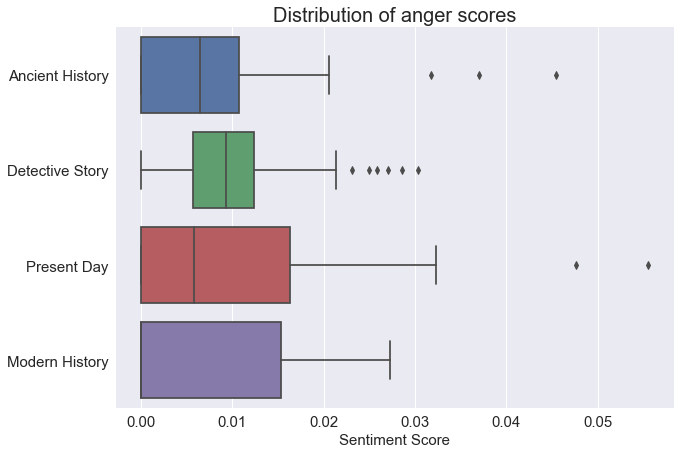

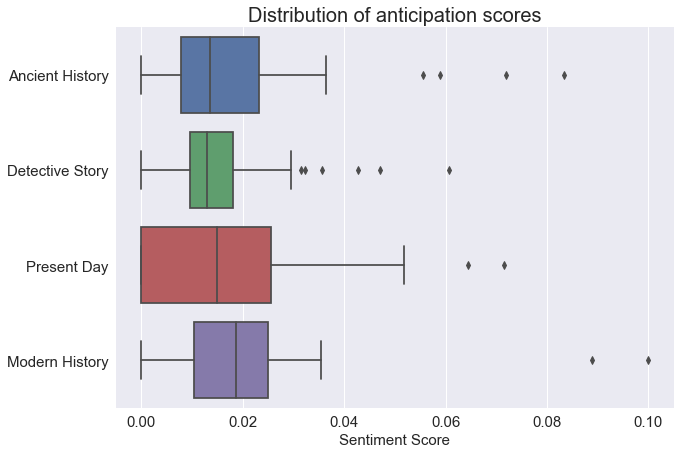

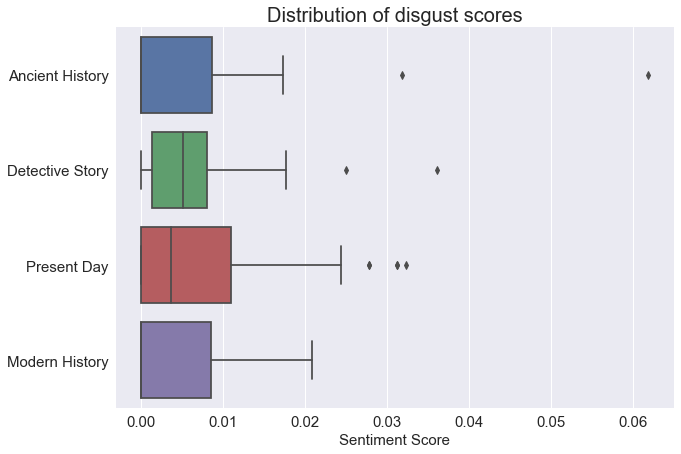

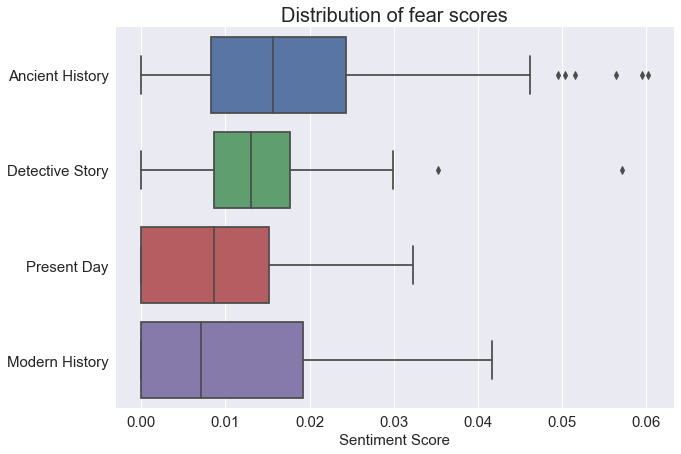

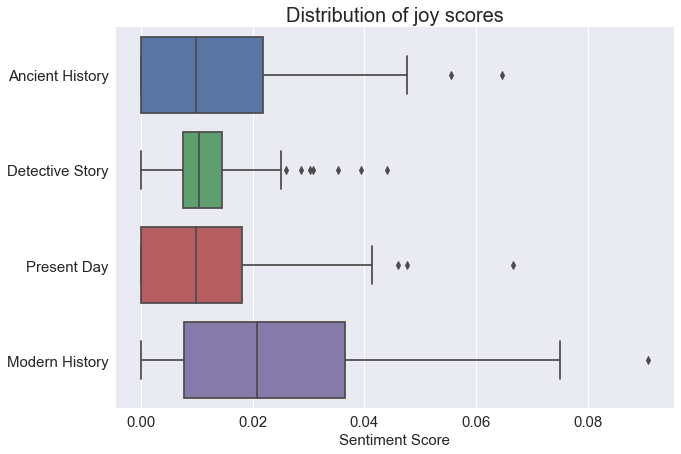

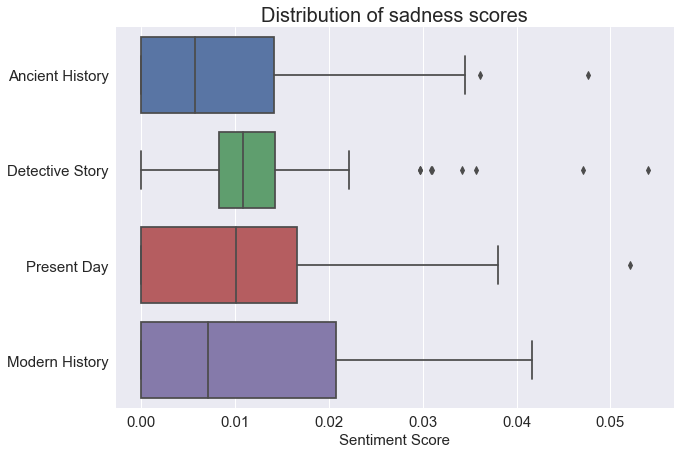

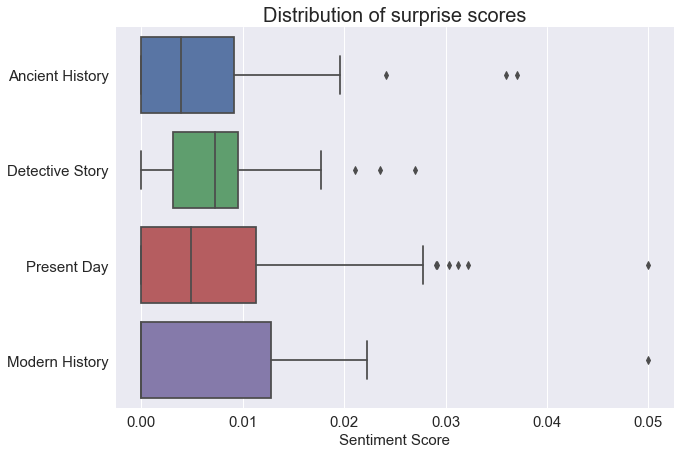

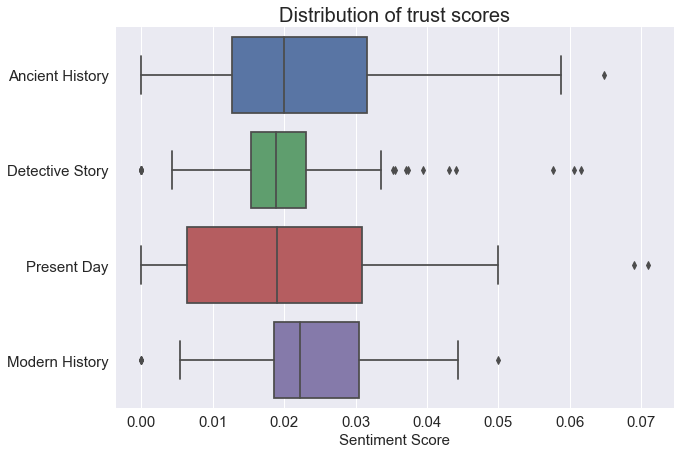

In [39]:
for col in ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']:
    plt.figure(figsize=(10, 7))
    sns.boxplot(x=col, y='period', data=df, notch=False)
    plt.xlabel('Sentiment Score', fontsize=15)
    plt.ylabel('')
    plt.title('Distribution of {} scores'.format(col), fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    # plt.savefig(boxplot.jpg, dpi=300)
    plt.show()

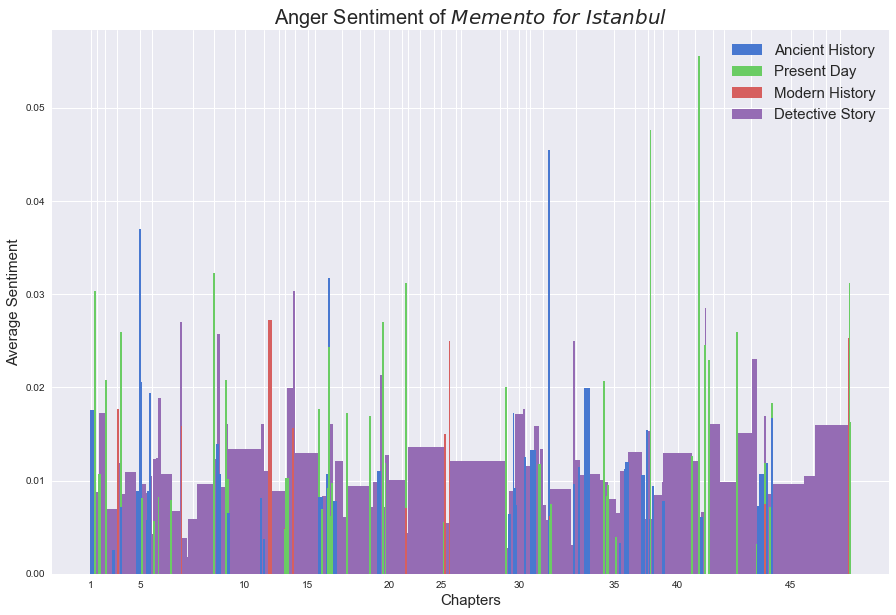

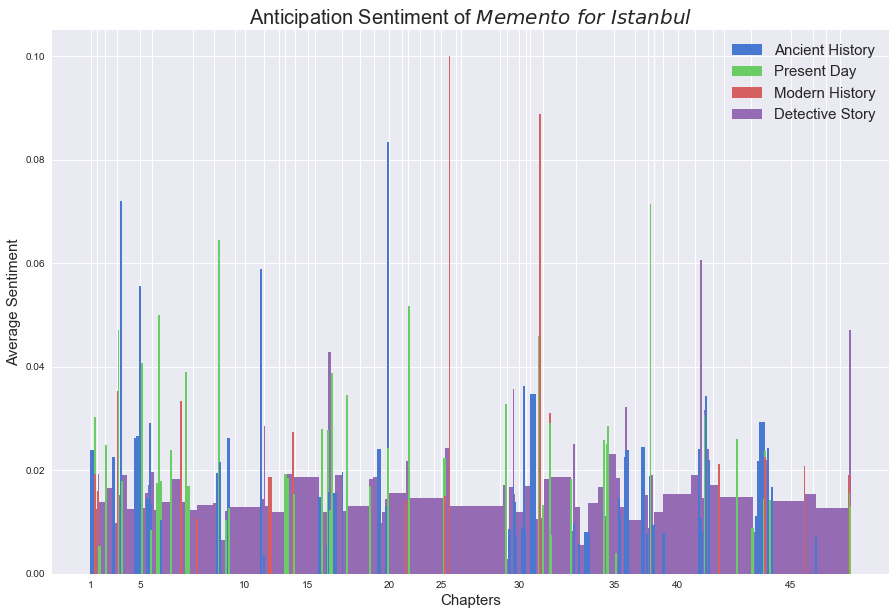

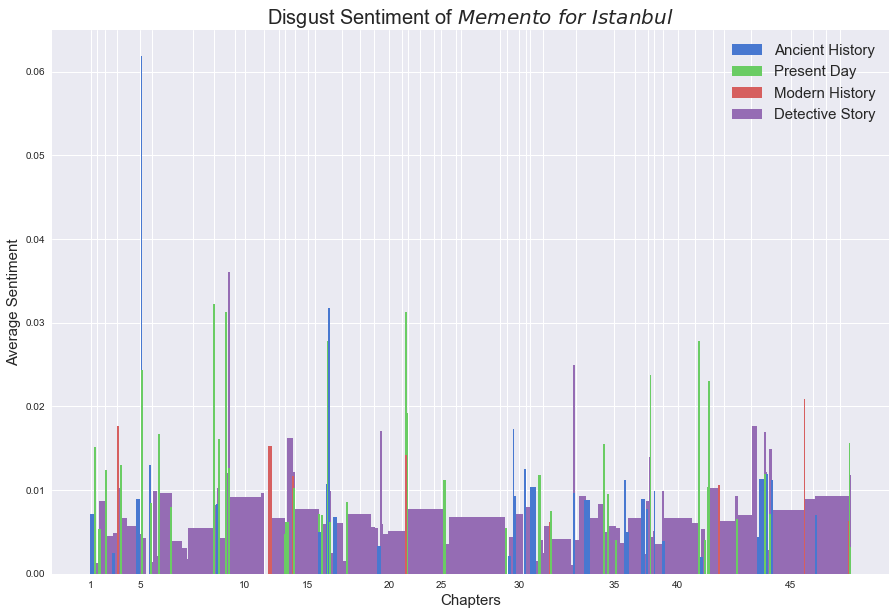

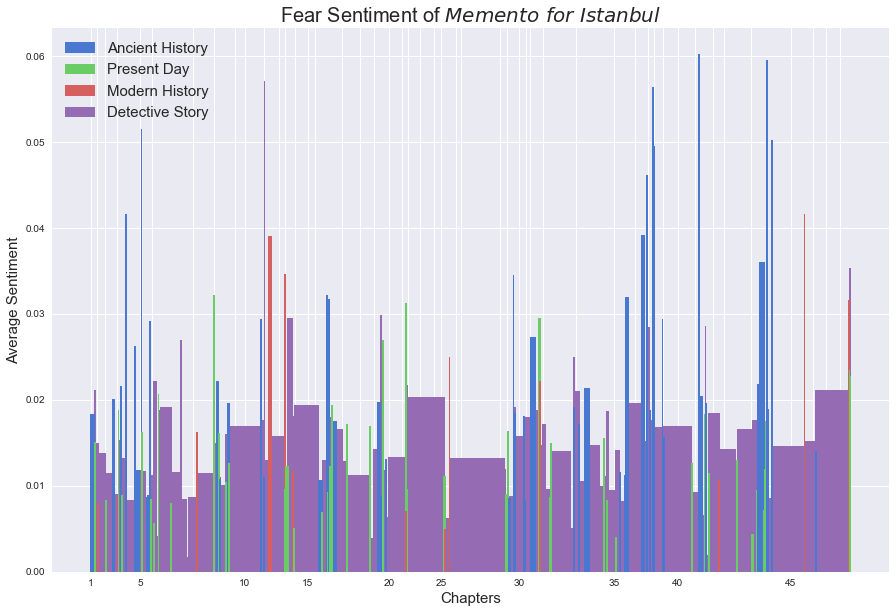

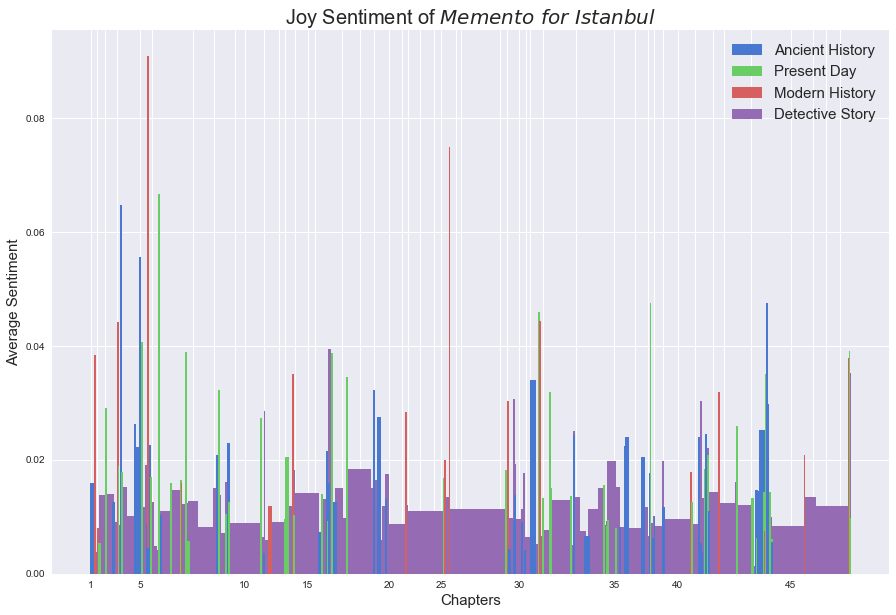

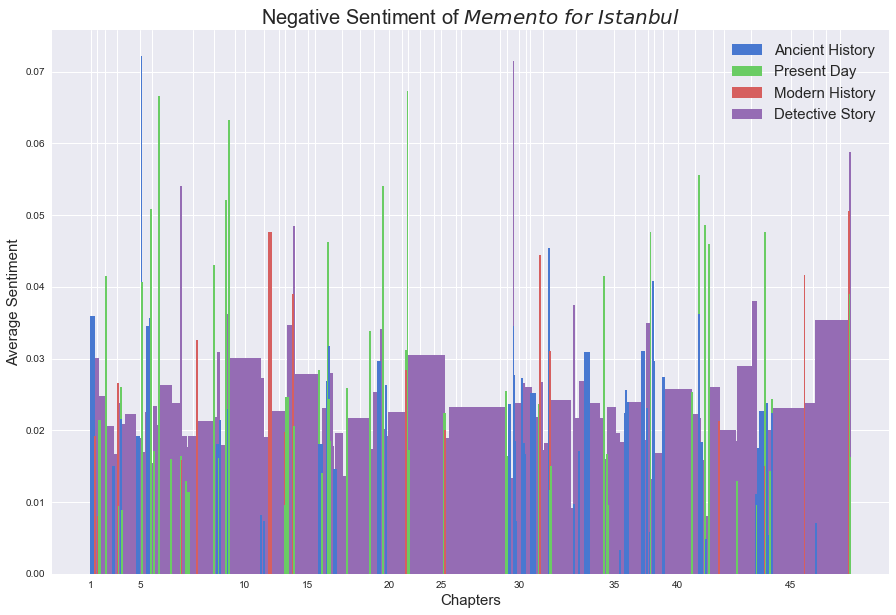

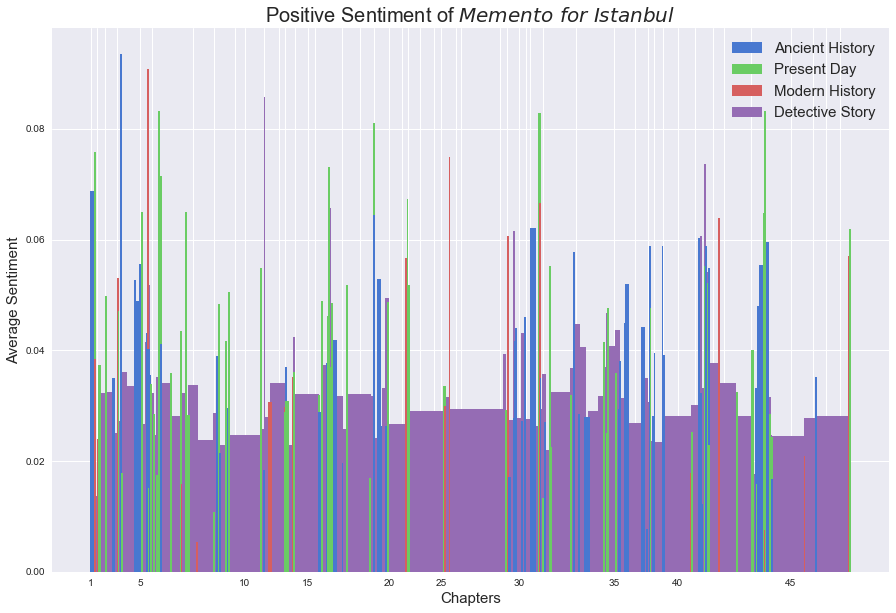

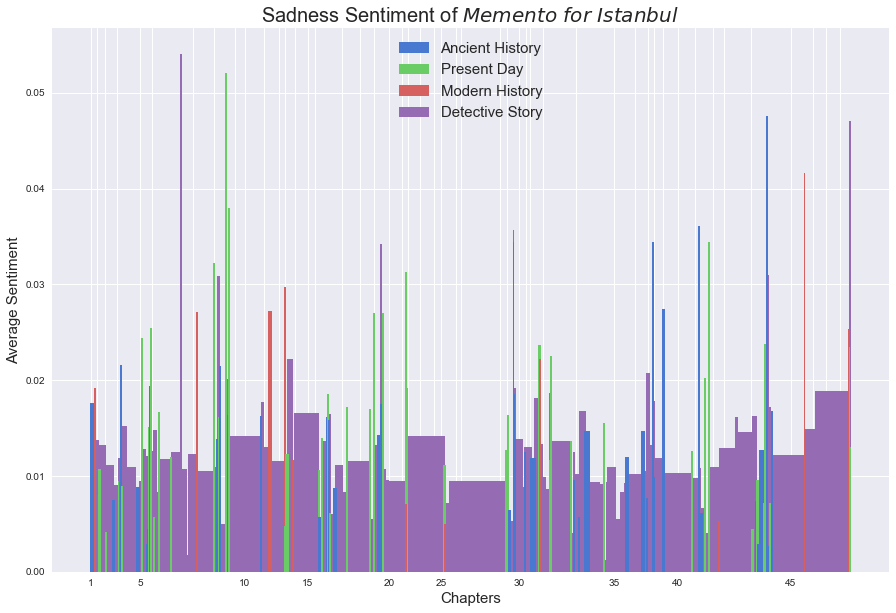

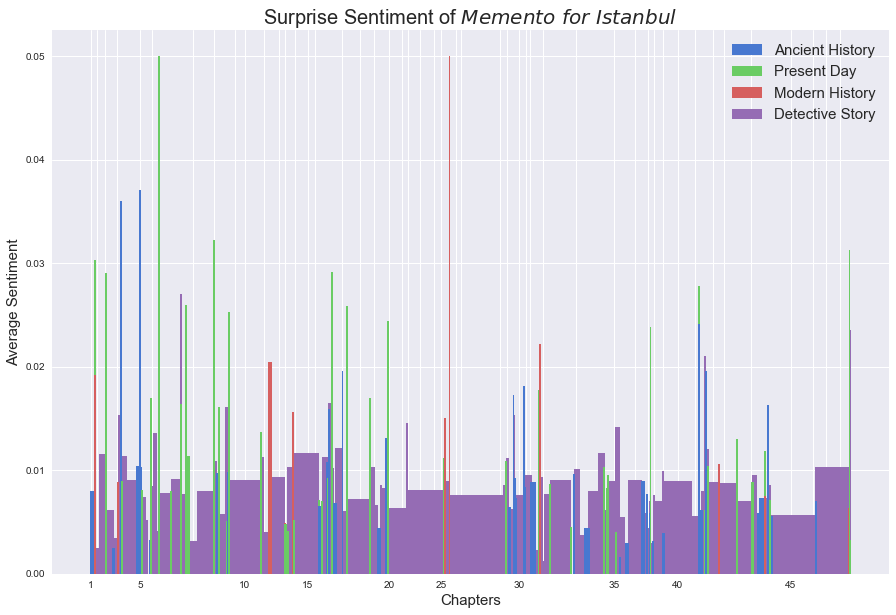

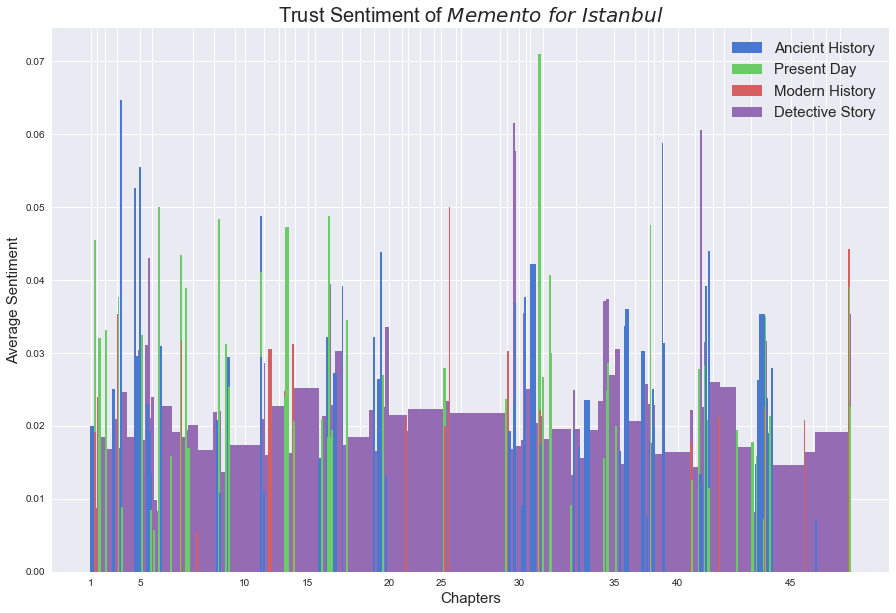

In [40]:
length = sum([section[3] for section in novel])
x = np.linspace(0, length - 1, num=length)

for emotion in emotions:
    y = [item for sublist in [[row[emotion]] * row['sentence_count'] for idx, row in df.iterrows()] for item in sublist]

    plt.figure(figsize=(15, 10))
    for section in book_indices:
        if book_indices[section][2] == 'Ancient History':
            plt.bar(x[book_indices[section][0]: book_indices[section][1]],
                     y[book_indices[section][0]: book_indices[section][1]],
                     label=book_indices[section][2], color='#4878d0', width=25, zorder=10)
        elif book_indices[section][2] == 'Modern History':
            plt.bar(x[book_indices[section][0]: book_indices[section][1]],
                     y[book_indices[section][0]: book_indices[section][1]],
                     label=book_indices[section][2], color='#d65f5f', width=25, zorder=10)
        elif book_indices[section][2] == 'Present Day':
            plt.bar(x[book_indices[section][0]: book_indices[section][1]],
                     y[book_indices[section][0]: book_indices[section][1]],
                     label=book_indices[section][2], color='#6acc64', width=25, zorder=10)
        elif book_indices[section][2] == 'Detective Story':
            plt.bar(x[book_indices[section][0]: book_indices[section][1]],
                     y[book_indices[section][0]: book_indices[section][1]],
                     label=book_indices[section][2], color='#956cb4', width=25, zorder=1)
    handles, labels = plt.gca().get_legend_handles_labels()
    handles = [handles[0], handles[2], handles[3], handles[1]]
    labels = [labels[0], labels[2], labels[3], labels[1]]
    plt.legend(handles, labels, loc='best', fontsize=15)
    plt.title(r'{} Sentiment of $Memento\ for\ Istanbul$'.format(emotion.title()), fontsize=20)
    plt.xlabel('Chapters', fontsize=15)
    plt.xticks(ticks=chapter_breaks, labels=[element + 1 if element == 0 or (element + 1) % 5 == 0 else '' for element in range(len(chapter_breaks))])
    plt.ylabel('Average Sentiment', fontsize=15)
    plt.show()

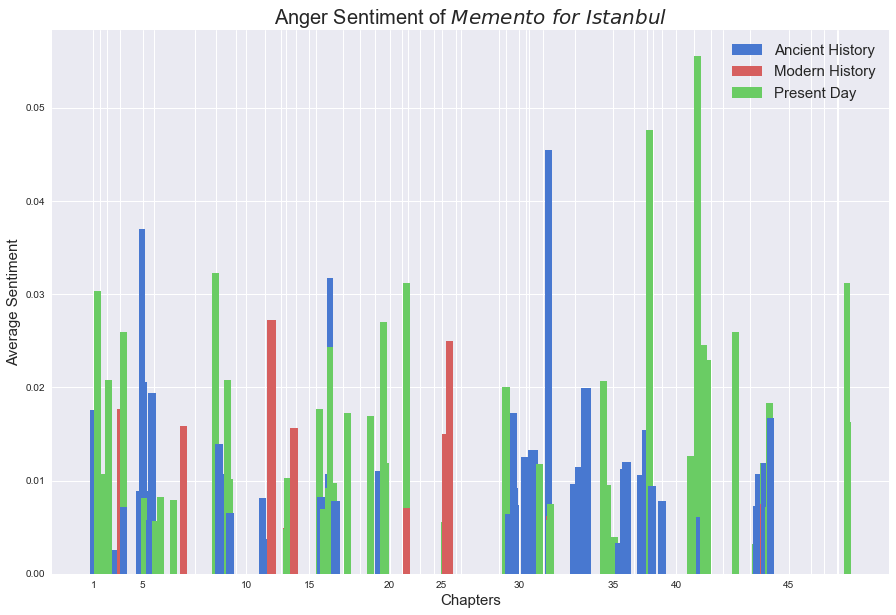

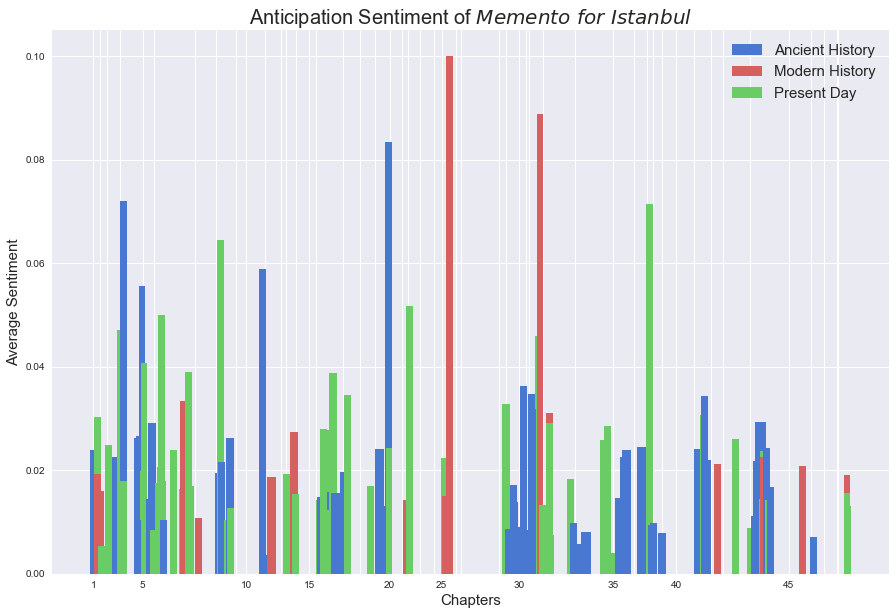

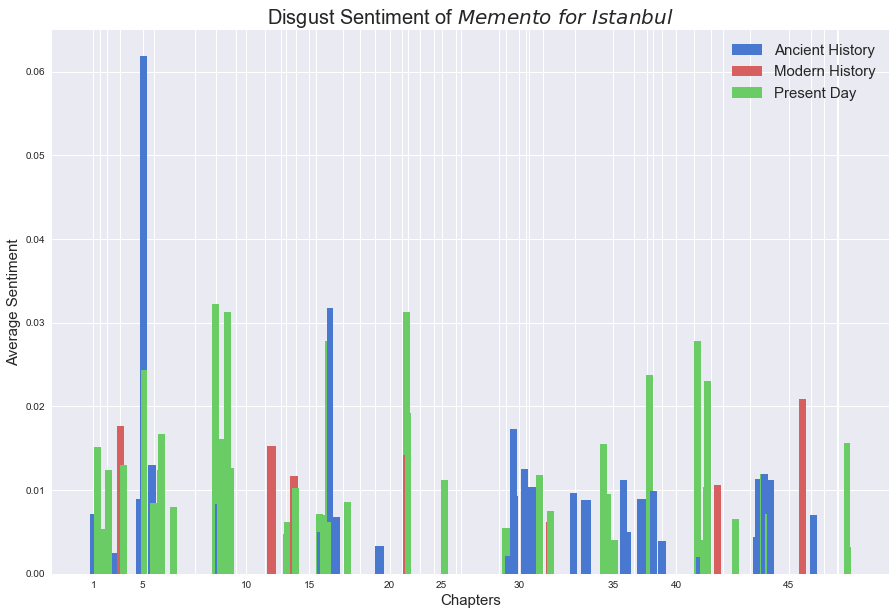

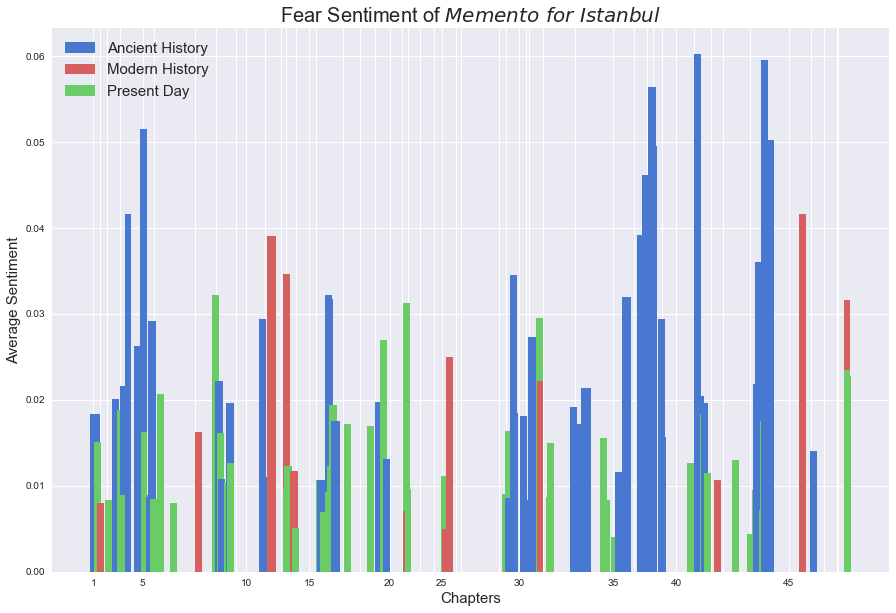

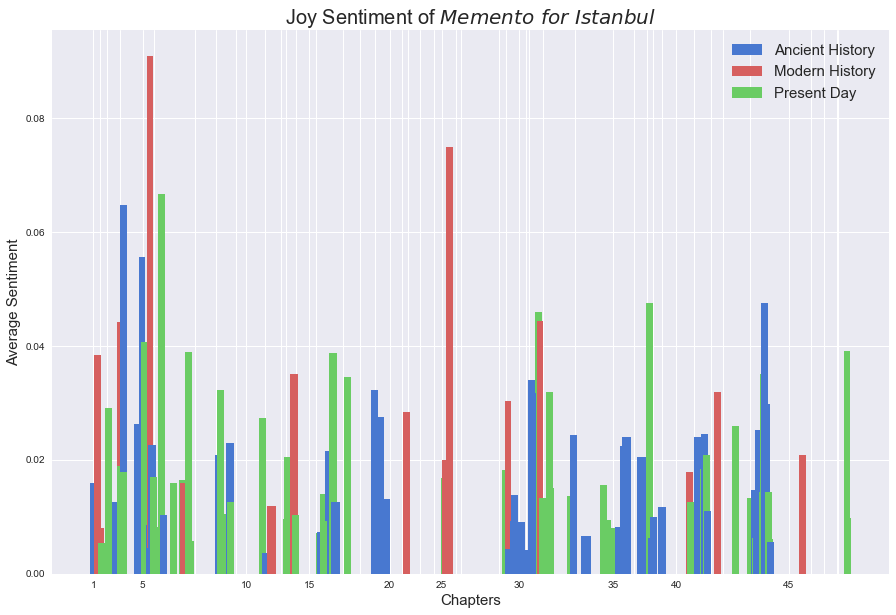

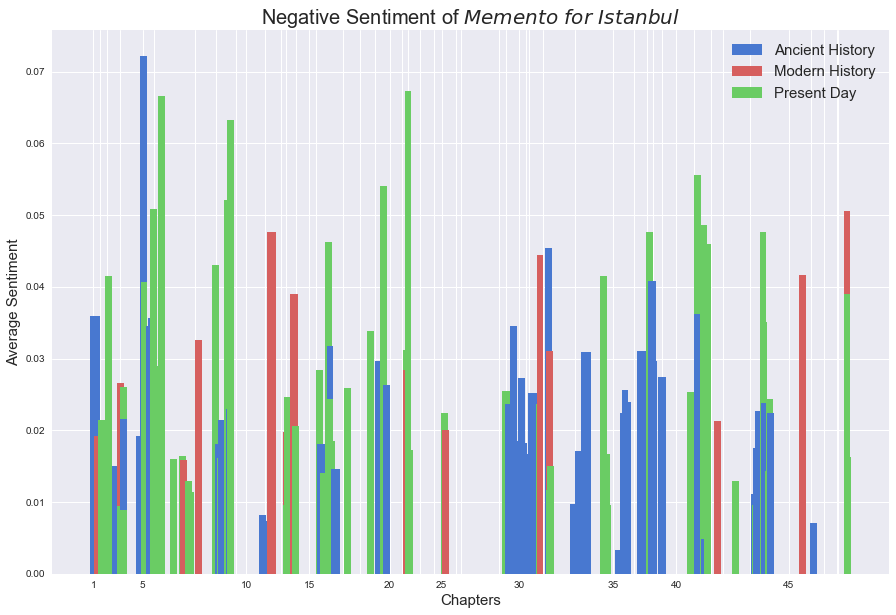

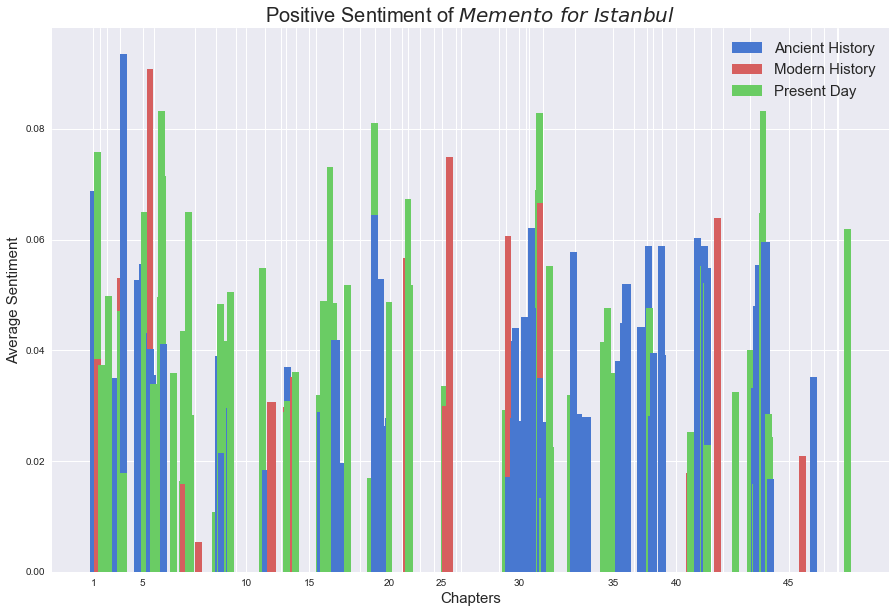

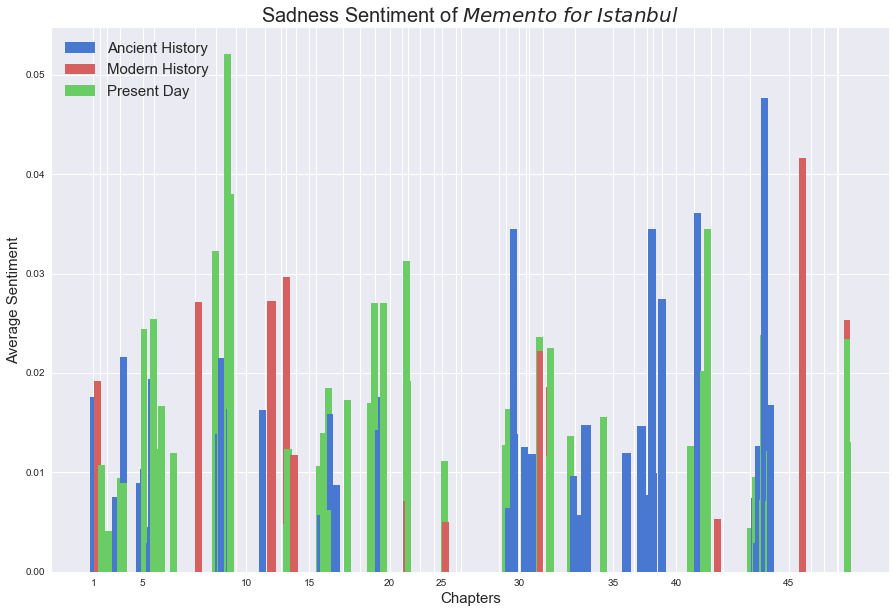

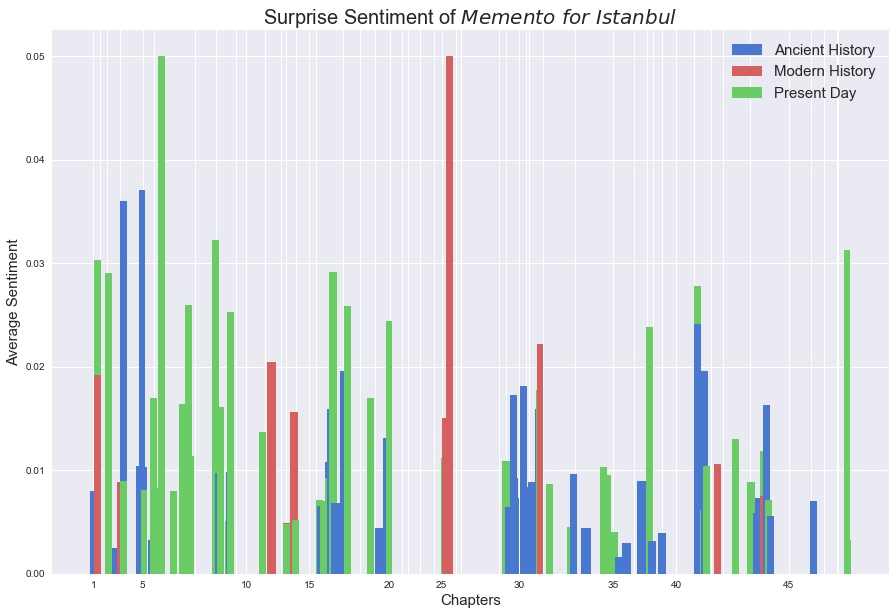

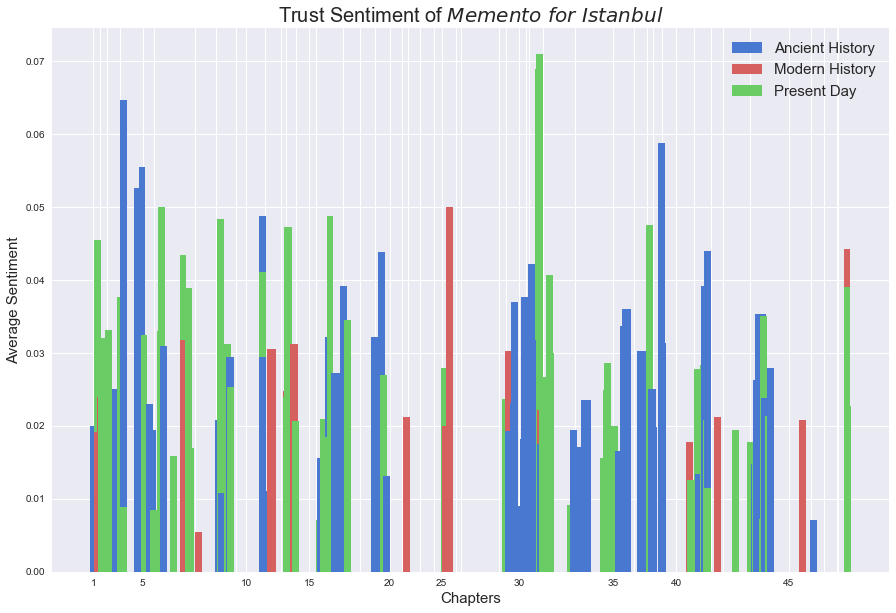

In [41]:
length = sum([section[3] for section in novel])
x = np.linspace(0, length - 1, num=length)

for emotion in emotions:
    y = [item for sublist in [[row[emotion]] * row['sentence_count'] for idx, row in df.iterrows()] for item in sublist]

    plt.figure(figsize=(15, 10))
    for section in book_indices:
        if book_indices[section][2] == 'Ancient History':
            plt.bar(x[book_indices[section][0]: book_indices[section][1]],
                     y[book_indices[section][0]: book_indices[section][1]],
                     label=book_indices[section][2], color='#4878d0', width=100, zorder=10)
        elif book_indices[section][2] == 'Modern History':
            plt.bar(x[book_indices[section][0]: book_indices[section][1]],
                     y[book_indices[section][0]: book_indices[section][1]],
                     label=book_indices[section][2], color='#d65f5f', width=100, zorder=10)
        elif book_indices[section][2] == 'Present Day':
            plt.bar(x[book_indices[section][0]: book_indices[section][1]],
                     y[book_indices[section][0]: book_indices[section][1]],
                     label=book_indices[section][2], color='#6acc64', width=100, zorder=10)
    handles, labels = plt.gca().get_legend_handles_labels()
    handles = [handles[0], handles[2], handles[1]]
    labels = [labels[0], labels[2], labels[1]]
    plt.legend(handles, labels, loc='best', fontsize=15)
    plt.title('{} Sentiment of $Memento\ for\ Istanbul$'.format(emotion.title()), fontsize=20)
    plt.xlabel('Chapters', fontsize=15)
    plt.xticks(ticks=chapter_breaks, labels=[element + 1 if element == 0 or (element + 1) % 5 == 0 else '' for element in range(len(chapter_breaks))])
    plt.ylabel('Average Sentiment', fontsize=15)
    plt.show()

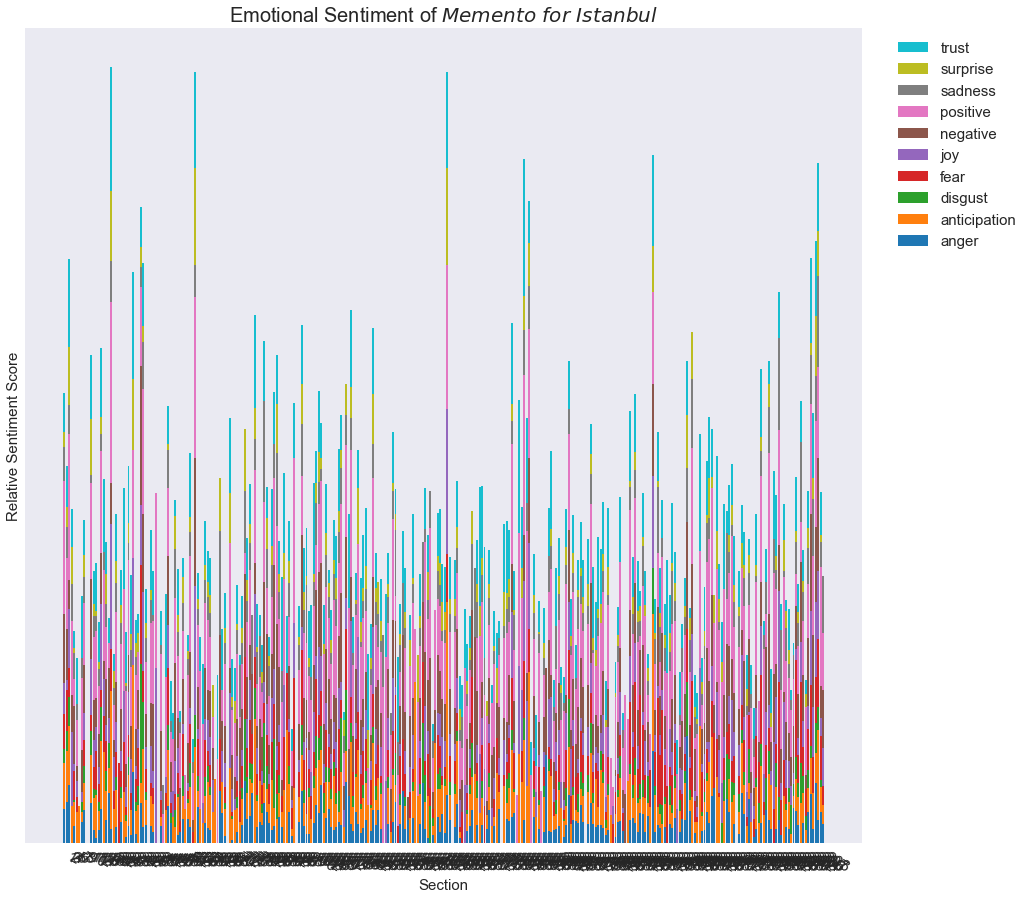

In [42]:
tab10 = matplotlib.cm.get_cmap('tab10')

sections = df['section'].tolist()
margin_bottom = np.zeros(len(sections))

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1)

for c, emotion in enumerate(emotions):
    y = np.array(df[emotion])
    plt.bar(sections, y, bottom=margin_bottom, label=emotion, color=(tab10(c)))
    margin_bottom += y

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='best', fontsize=15, bbox_to_anchor=(1.2, 1))
plt.title('Emotional Sentiment of $Memento\ for\ Istanbul$', fontsize=20)
plt.xticks(sections, sections, rotation=-30, ha='left', fontsize=15)
plt.xlabel('Section', fontsize=15)
plt.ylabel('Relative Sentiment Score', fontsize=15)
plt.yticks([])
ax.grid(False)
plt.show()

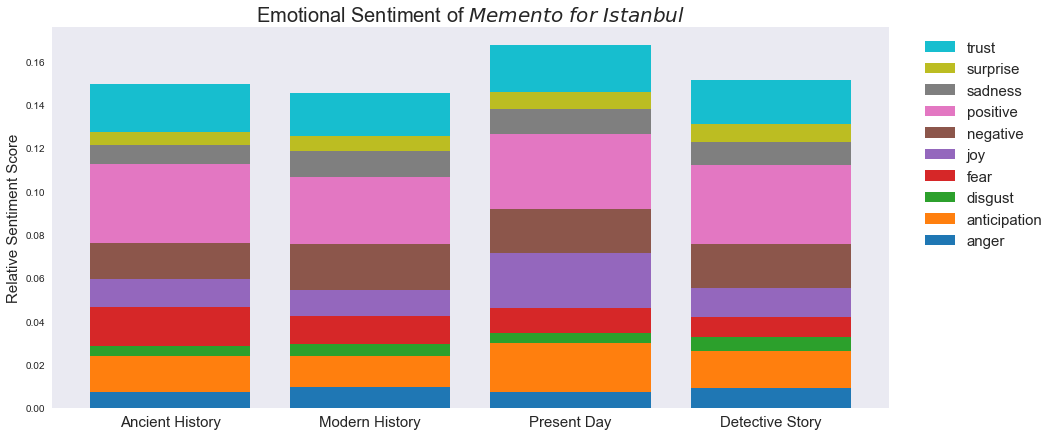

In [43]:
tab10 = matplotlib.cm.get_cmap('tab10')

periods = ['Ancient History', 'Modern History', 'Present Day', 'Detective Story']
margin_bottom = np.zeros(len(periods))

fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1, 1, 1)

for c, emotion in enumerate(emotions):
    y = df.groupby('period')[emotion].mean()
    plt.bar(periods, y, bottom=margin_bottom, label=emotion, color=(tab10(c)))
    margin_bottom += y

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='best', fontsize=15, bbox_to_anchor=(1.2, 1))
plt.title('Emotional Sentiment of $Memento\ for\ Istanbul$', fontsize=20)
plt.xticks(periods, periods, fontsize=15)
plt.ylabel('Relative Sentiment Score', fontsize=15)
# plt.yticks([])
ax.grid(False)
plt.show()

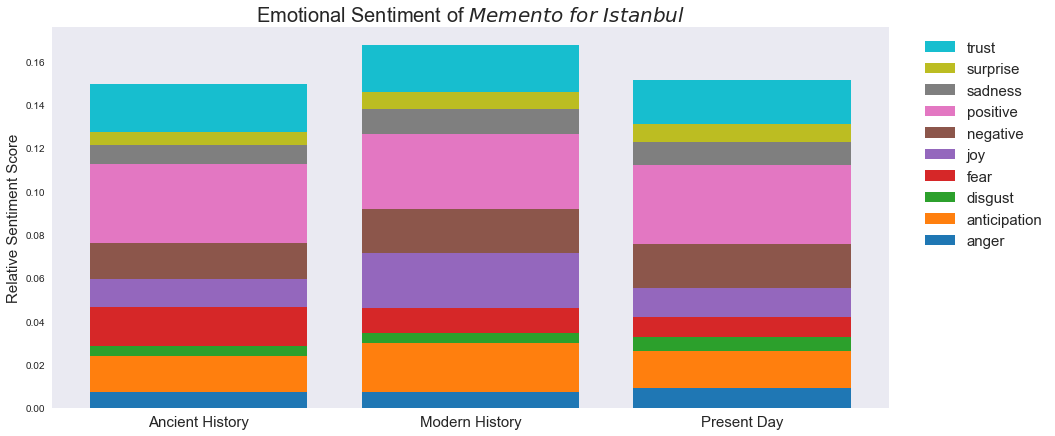

In [44]:
tab10 = matplotlib.cm.get_cmap('tab10')

df2 = df[df['period'].isin(['Ancient History', 'Modern History', 'Present Day'])]

periods = ['Ancient History', 'Modern History', 'Present Day']
margin_bottom = np.zeros(len(periods))

fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1, 1, 1)

for c, emotion in enumerate(emotions):
    y = df2.groupby('period')[emotion].mean()
    plt.bar(periods, y, bottom=margin_bottom, label=emotion, color=(tab10(c)))
    margin_bottom += y

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='best', fontsize=15, bbox_to_anchor=(1.2, 1))
plt.title('Emotional Sentiment of $Memento\ for\ Istanbul$', fontsize=20)
plt.xticks(periods, periods, fontsize=15)
plt.ylabel('Relative Sentiment Score', fontsize=15)
# plt.yticks([])
ax.grid(False)
plt.show()

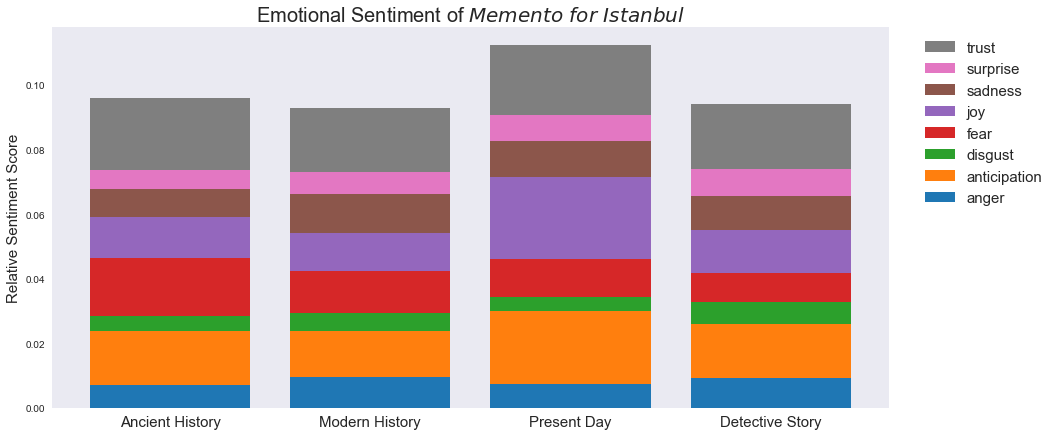

In [45]:
tab10 = matplotlib.cm.get_cmap('tab10')

periods = ['Ancient History', 'Modern History', 'Present Day', 'Detective Story']
margin_bottom = np.zeros(len(periods))

fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1, 1, 1)

for c, emotion in enumerate(['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']):
    y = df.groupby('period')[emotion].mean()
    plt.bar(periods, y, bottom=margin_bottom, label=emotion, color=(tab10(c)))
    margin_bottom += y

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='best', fontsize=15, bbox_to_anchor=(1.2, 1))
plt.title('Emotional Sentiment of $Memento\ for\ Istanbul$', fontsize=20)
plt.xticks(periods, periods, fontsize=15)
plt.ylabel('Relative Sentiment Score', fontsize=15)
# plt.yticks([])
ax.grid(False)
plt.show()

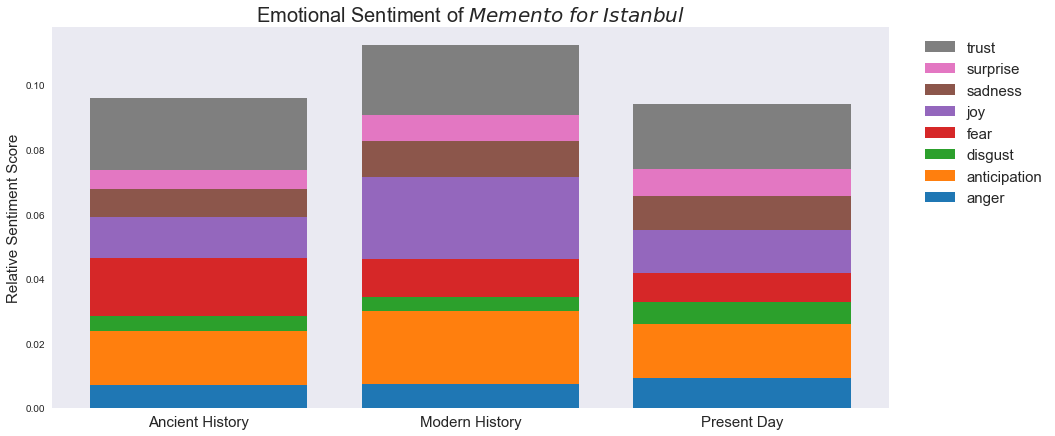

In [46]:
tab10 = matplotlib.cm.get_cmap('tab10')

df2 = df[df['period'].isin(['Ancient History', 'Modern History', 'Present Day'])]

periods = ['Ancient History', 'Modern History', 'Present Day']
margin_bottom = np.zeros(len(periods))

fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1, 1, 1)

for c, emotion in enumerate(['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']):
    y = df2.groupby('period')[emotion].mean()
    plt.bar(periods, y, bottom=margin_bottom, label=emotion, color=(tab10(c)))
    margin_bottom += y

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='best', fontsize=15, bbox_to_anchor=(1.2, 1))
plt.title('Emotional Sentiment of $Memento\ for\ Istanbul$', fontsize=20)
plt.xticks(periods, periods, fontsize=15)
plt.ylabel('Relative Sentiment Score', fontsize=15)
# plt.yticks([])
ax.grid(False)
plt.show()

In [47]:
df.head()

,section,period,text,sentence_count,compound,pos,neg,neu,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,word_count
0,1,Ancient History,Byzantium\n\nKing Byzas’ Fabled City\n\n\n\nD\...,55,0.04070,0.090073,0.061400,0.848527,0.017586,0.023981,0.007194,0.018385,0.015987,0.035971,0.068745,0.017586,0.007994,0.019984,1251
1,2,Detective Story,The Crescent and the Star\n\nThe victim’s eyes...,8,-0.12115,0.009125,0.061125,0.929750,0.021164,0.026455,0.010582,0.021164,0.005291,0.026455,0.037037,0.015873,0.010582,0.021164,189
2,3,Present Day,"Two battered old ferries, those long-suffering...",2,0.58420,0.140500,0.000000,0.859500,0.030303,0.030303,0.015152,0.015152,0.030303,0.015152,0.075758,0.015152,0.030303,0.045455,66
3,4,Modern History,"I was taken back to the old days, the good old...",1,0.68580,0.170000,0.058000,0.772000,0.000000,0.019231,0.000000,0.000000,0.038462,0.019231,0.038462,0.019231,0.019231,0.019231,52
4,5,Detective Story,I suddenly felt someone’s eyes on me. Lifting ...,43,-0.18296,0.039953,0.075581,0.884465,0.008761,0.012516,0.001252,0.015019,0.003755,0.030038,0.013767,0.013767,0.002503,0.008761,799


In [48]:
df_ave = df.groupby('period')[['compound', 'pos', 'neg',
       'neu', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative',
       'positive', 'sadness', 'surprise', 'trust']].mean()

In [49]:
df_ave.head()

,compound,pos,neg,neu,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
period,,,,,,,,,,,,,,
Ancient History,0.138068,0.070968,0.038311,0.890732,0.007171,0.016683,0.004589,0.017897,0.012925,0.016626,0.036733,0.008468,0.006038,0.022131
Detective Story,-0.034454,0.072087,0.069192,0.858728,0.009551,0.014237,0.005533,0.013174,0.011686,0.021205,0.031238,0.011949,0.006969,0.019726
Modern History,0.175897,0.083966,0.032749,0.883294,0.007282,0.022584,0.004475,0.011657,0.025590,0.020053,0.034961,0.011180,0.007860,0.021648
Present Day,0.143658,0.082560,0.037913,0.879493,0.009290,0.016794,0.006720,0.009060,0.013212,0.020476,0.036389,0.010624,0.008323,0.020244


In [50]:
df_ave.to_csv('df_ave.csv')

In [51]:
min_emotion = min(df_ave[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']].min())
max_emotion = max(df_ave[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']].max())

min_sentiment = min(df_ave[['pos', 'neg', 'neu']].min())
max_sentiment = max(df_ave[['pos', 'neg', 'neu']].max())

min_compound = df_ave['compound'].min()
max_compound = df_ave['compound'].max()

df_ave_norm = df_ave[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative',
       'positive', 'sadness', 'surprise', 'trust']].apply(lambda x: (x - min_emotion) / (max_emotion - min_emotion))

df_ave_norm[['pos', 'neg', 'neu']] = df_ave[['pos', 'neg', 'neu']].apply(lambda x: (x - min_sentiment) / (max_sentiment - min_sentiment))

df_ave_norm['compound'] = df_ave['compound'].apply(lambda x: (x - df_ave['compound'].min()) / (df_ave['compound'].max() - df_ave['compound'].min())) * 2 - 1

df_ave_norm = df_ave_norm[['compound', 'pos', 'neg', 'neu', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']]

df_ave_norm.head()

,compound,pos,neg,neu,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
period,,,,,,,,,,,,,,
Ancient History,0.640325,0.044545,0.006483,1.000000,0.083570,0.378455,0.003537,0.416096,0.261956,0.376688,1.000000,0.123785,0.048444,0.547330
Detective Story,-1.000000,0.045849,0.042474,0.962699,0.157367,0.302623,0.032800,0.269672,0.223558,0.518628,0.829645,0.231699,0.077307,0.472793
Modern History,1.000000,0.059694,0.000000,0.991331,0.087038,0.561394,0.000000,0.222657,0.654559,0.482934,0.945069,0.207857,0.104931,0.532360
Present Day,0.693473,0.058056,0.006019,0.986901,0.149262,0.381888,0.069609,0.142125,0.270865,0.496048,0.989333,0.190612,0.119279,0.488830


In [52]:
(df_ave['compound'] - min(df_ave['compound'])) / (max(df_ave['compound']) - min(df_ave['compound'])) * 2 - 1

period
Ancient History    0.640325
Detective Story   -1.000000
Modern History     1.000000
Present Day        0.693473
Name: compound, dtype: float64

In [53]:
df_ave.to_csv('averages.csv')

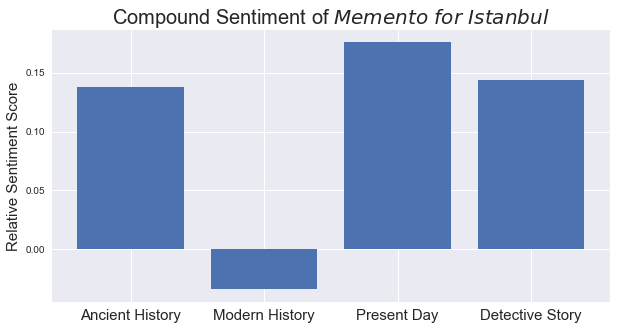

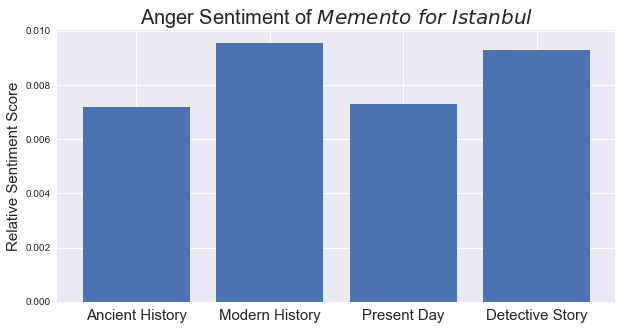

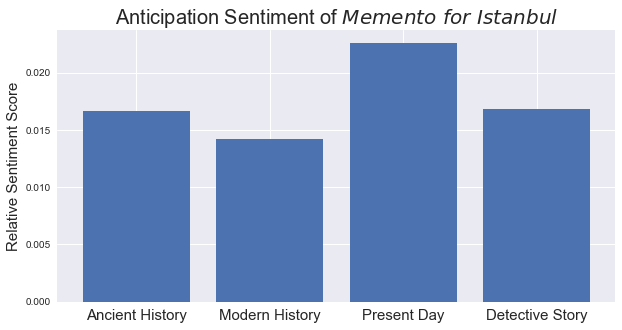

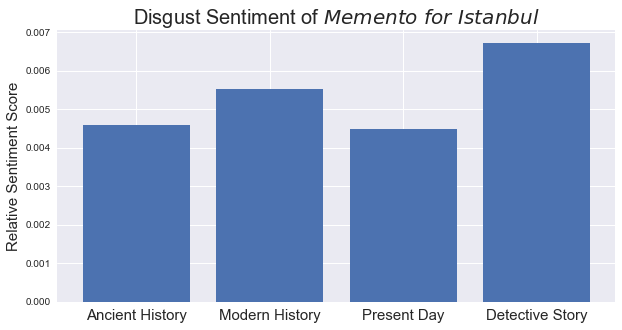

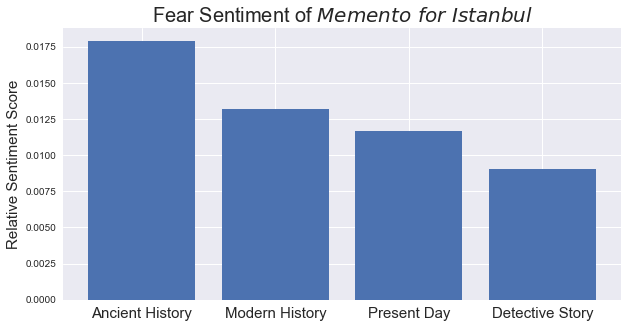

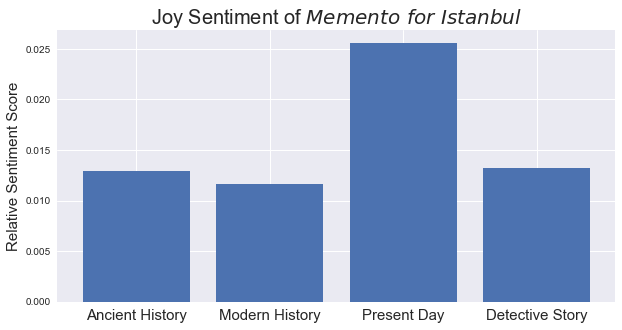

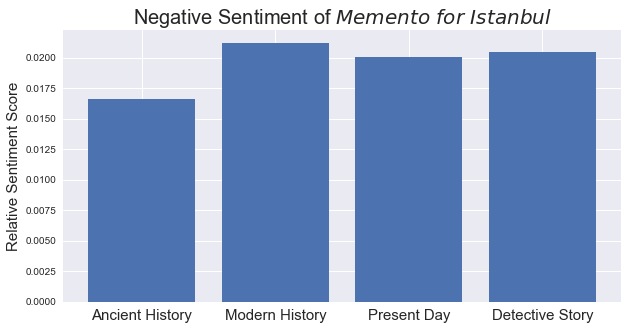

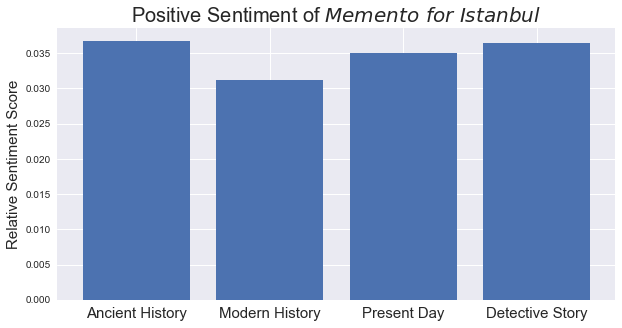

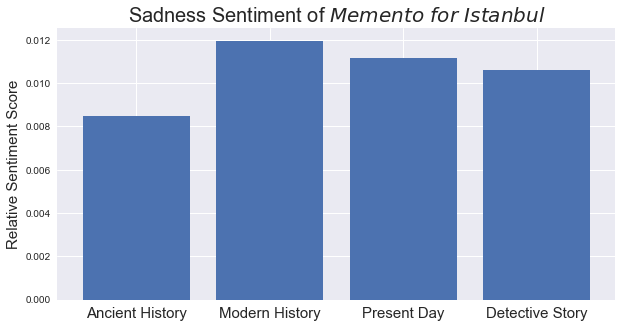

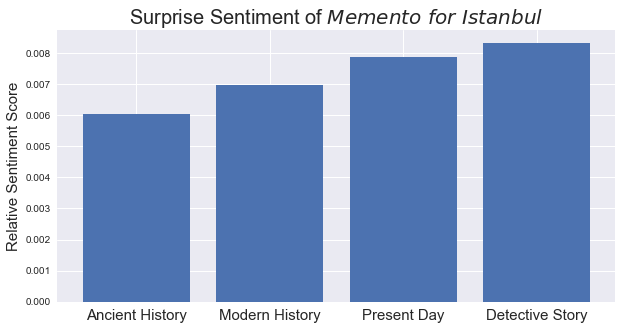

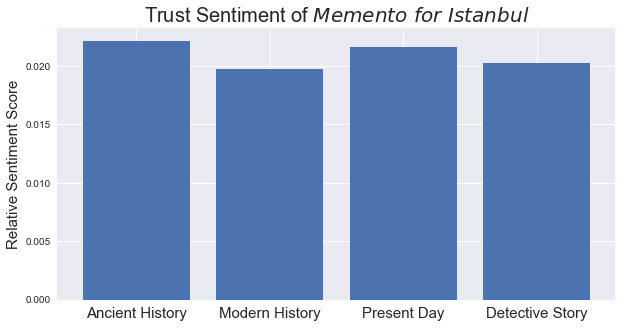

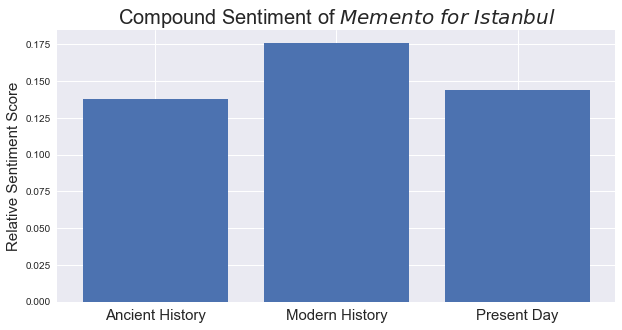

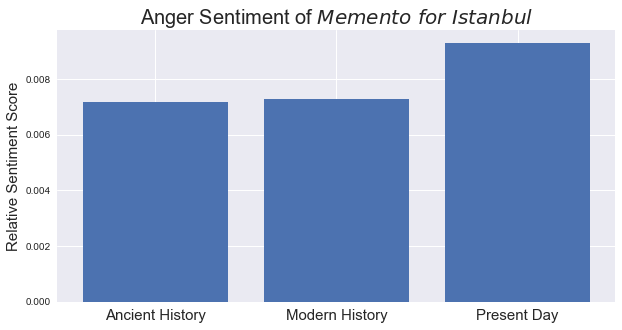

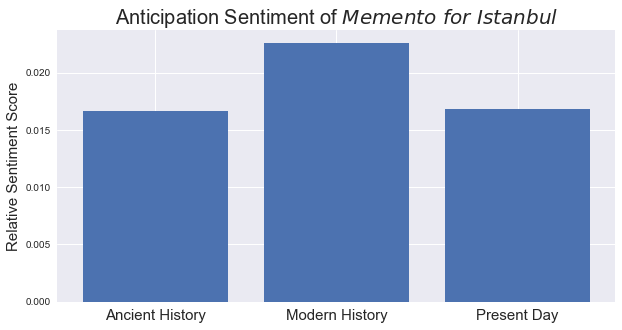

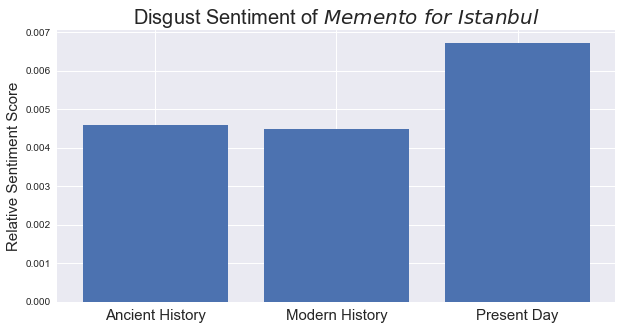

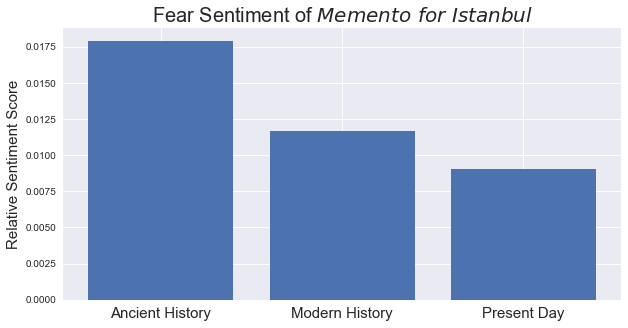

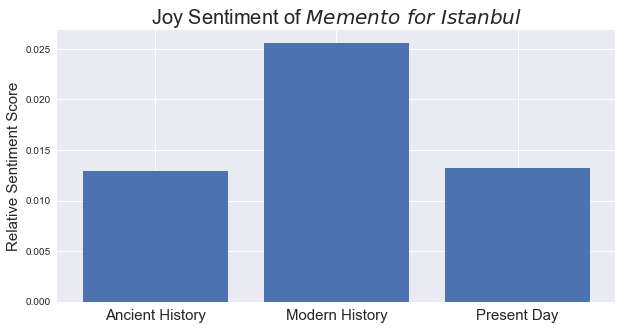

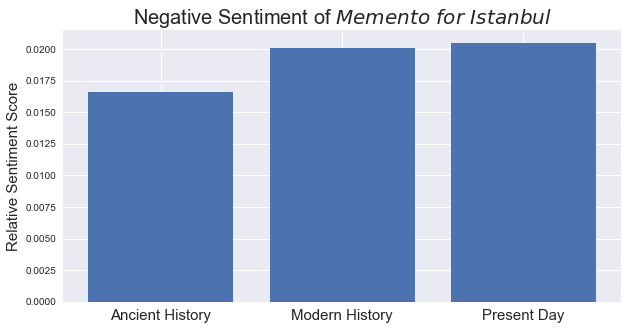

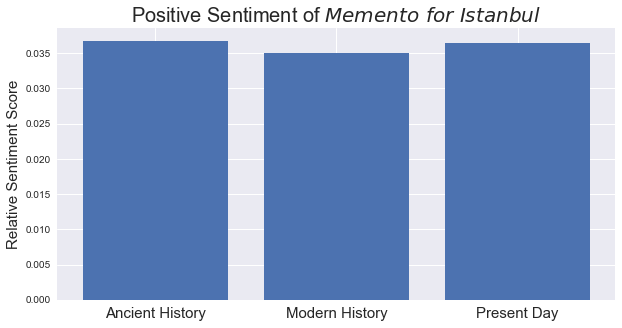

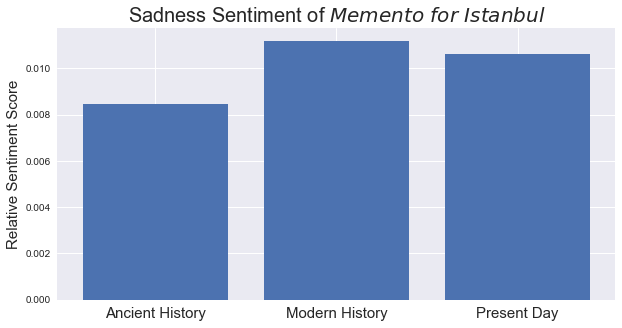

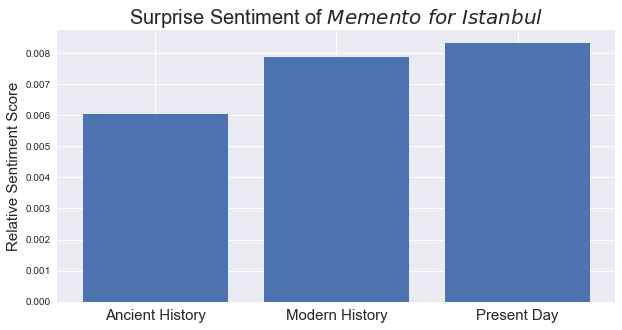

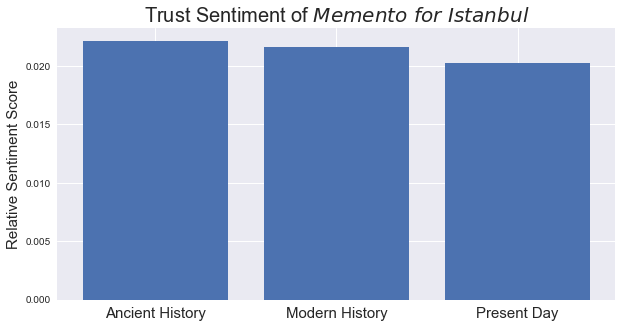

In [54]:
for periods in [['Ancient History', 'Modern History', 'Present Day', 'Detective Story'], ['Ancient History', 'Modern History', 'Present Day']]:
    for col in ['compound', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']:
        plt.figure(figsize=(10, 5))
        plt.bar(x=periods, height=df_ave[df_ave.index.isin(periods)][col])
        plt.title('{} Sentiment of $Memento\ for\ Istanbul$'.format(col.title()), fontsize=20)
        plt.ylabel('Relative Sentiment Score', fontsize=15)
        plt.xticks(periods, periods, fontsize=15)
        plt.show()

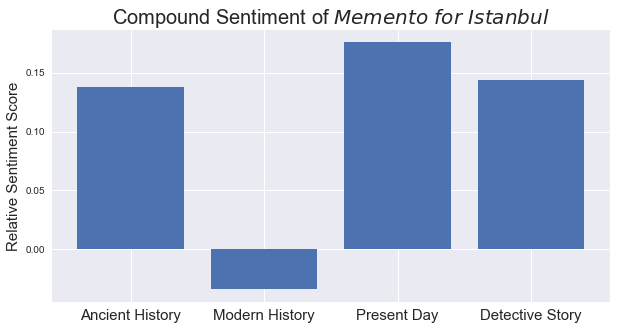

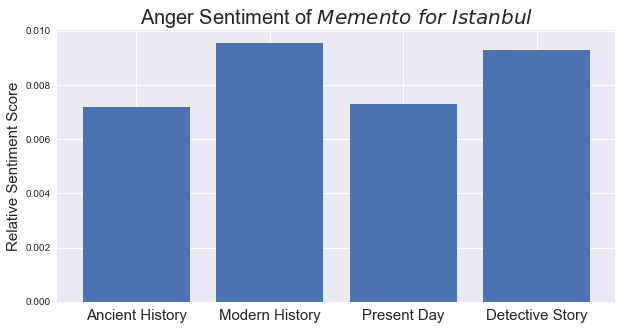

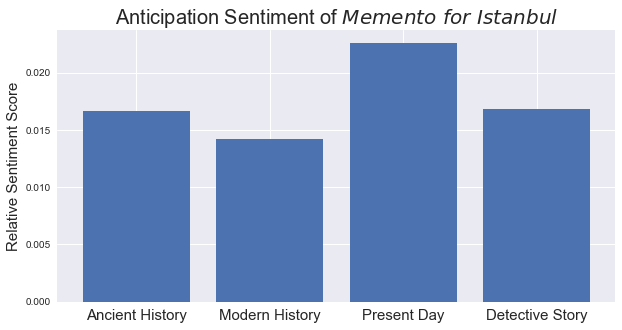

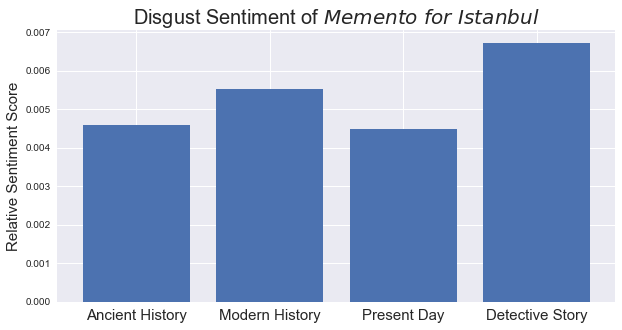

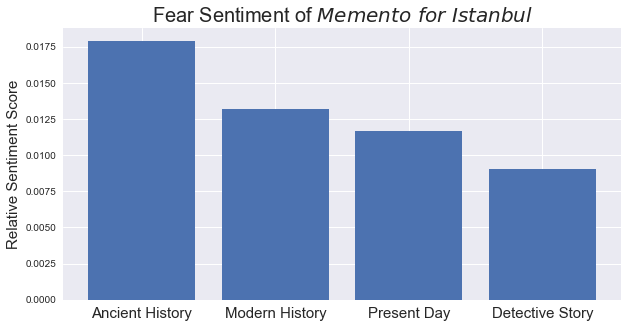

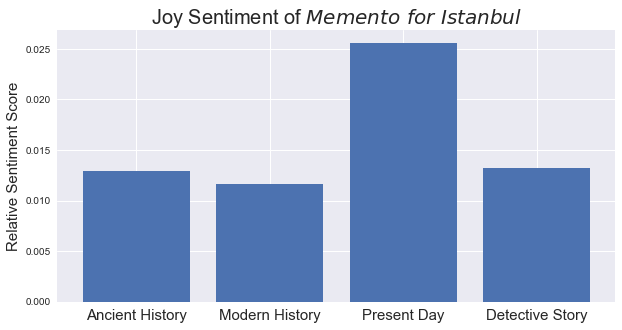

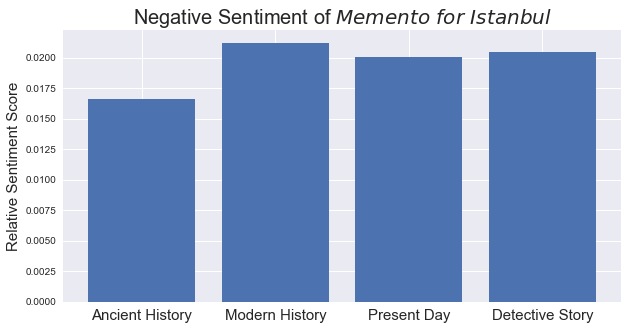

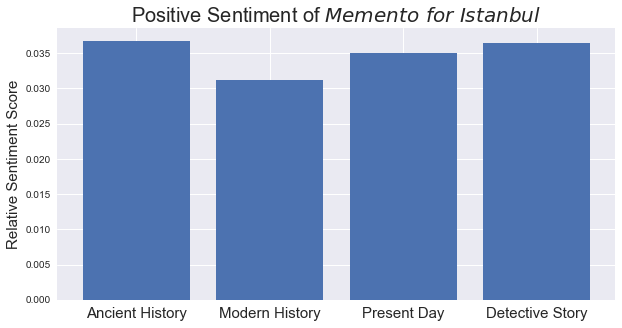

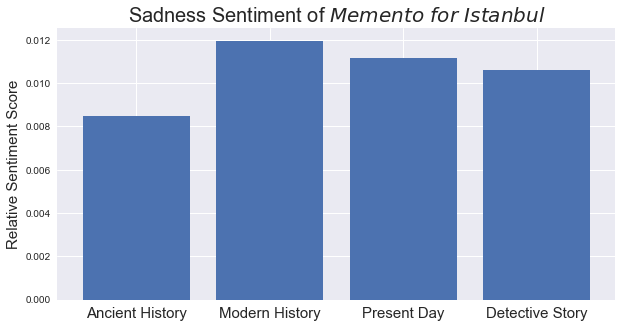

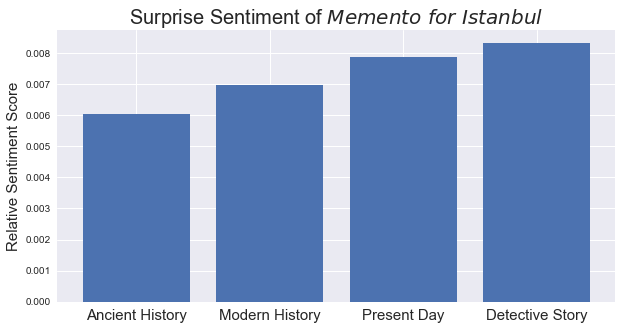

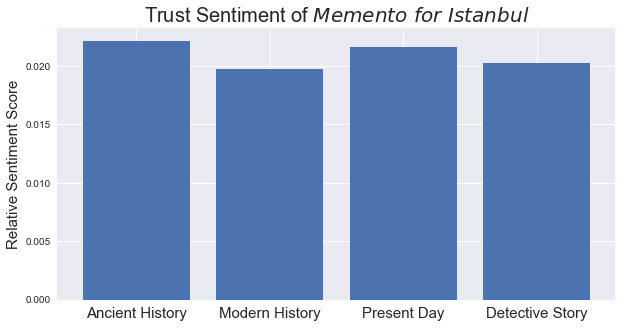

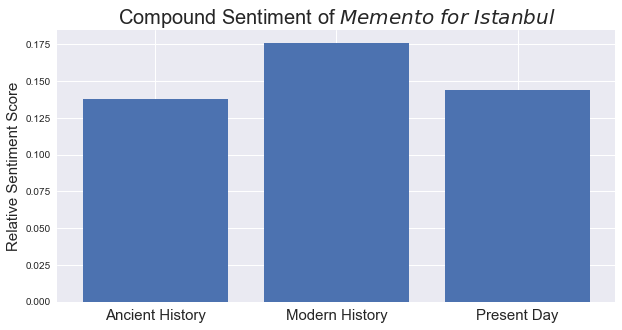

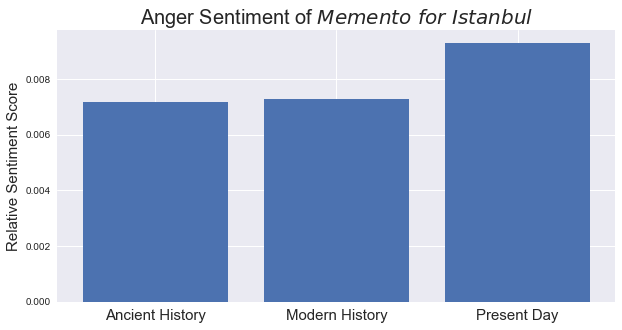

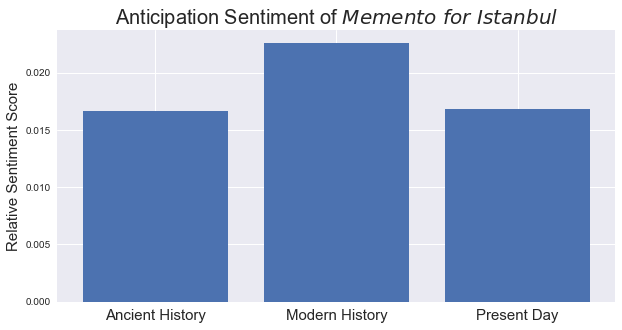

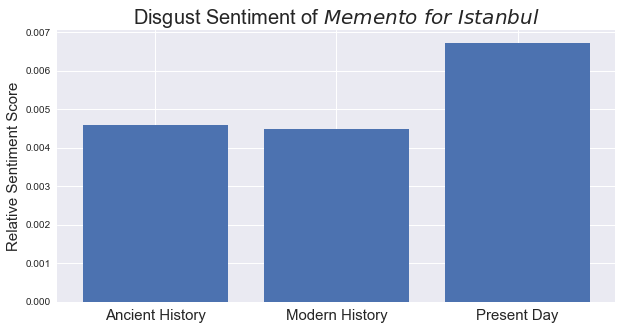

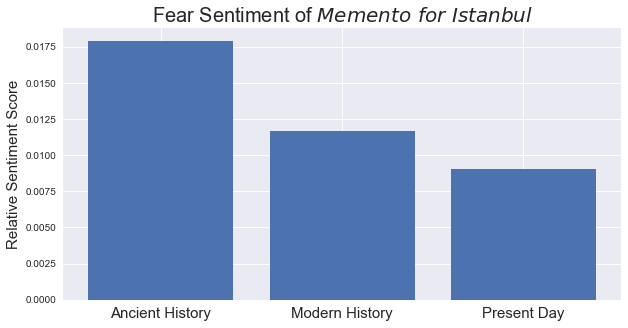

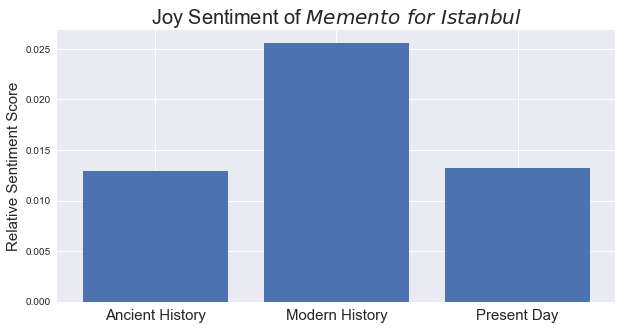

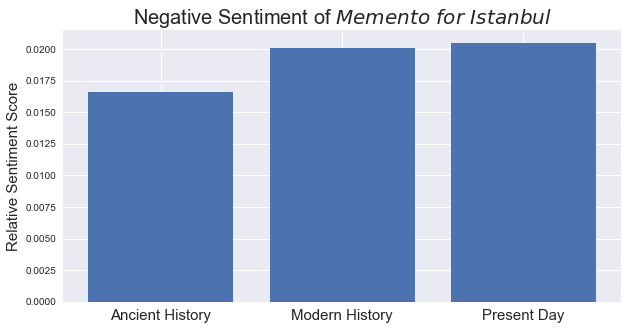

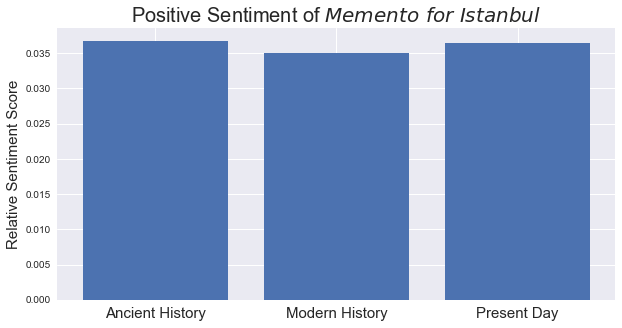

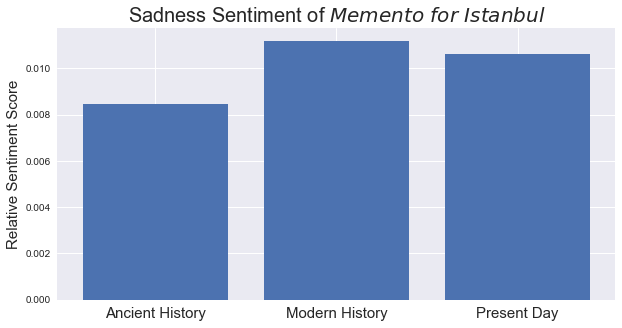

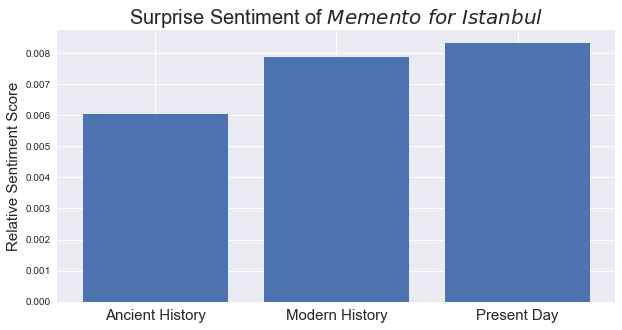

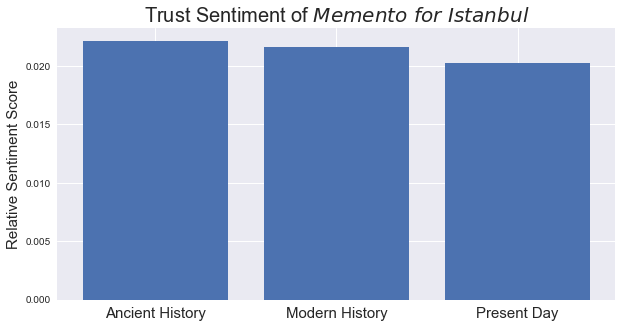

In [55]:
for periods in [['Ancient History', 'Modern History', 'Present Day', 'Detective Story'], ['Ancient History', 'Modern History', 'Present Day']]:
    for col in ['compound', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']:
        plt.figure(figsize=(10, 5))
        plt.bar(x=periods, height=df_ave[df_ave.index.isin(periods)][col])
        plt.title('{} Sentiment of $Memento\ for\ Istanbul$'.format(col.title()), fontsize=20)
        plt.ylabel('Relative Sentiment Score', fontsize=15)
        plt.xticks(periods, periods, fontsize=15)
        plt.show()

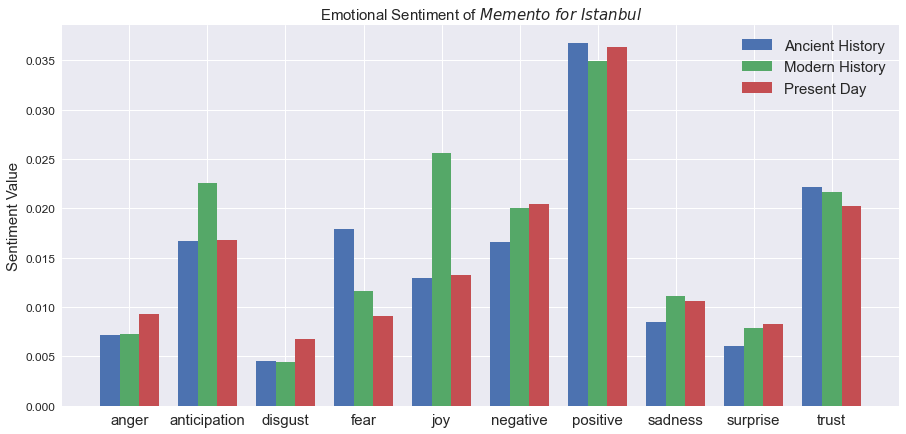

In [56]:
N = 10
emotions = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']

ancient = df_ave.loc['Ancient History'][['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']]
modern = df_ave.loc['Modern History'][['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']]
present = df_ave.loc['Present Day'][['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']]

ind = np.arange(N)  # the x locations for the groups
width = 0.25       # the width of the bars

fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, ancient, width)
rects2 = ax.bar(ind+width, modern, width)
rects3 = ax.bar(ind+2*width, present, width)

ax.set_ylabel('Sentiment Value', fontsize=15)
ax.set_title('Emotional Sentiment of $Memento\ for\ Istanbul$', fontsize=15)
ax.set_xticks(ind + width)
ax.tick_params(labelsize=12)
ax.set_xticklabels(['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust'], fontsize=15)

ax.legend((rects1[0], rects2[0], rects3[0]), ('Ancient History', 'Modern History', 'Present Day'), fontsize=15)

plt.show()

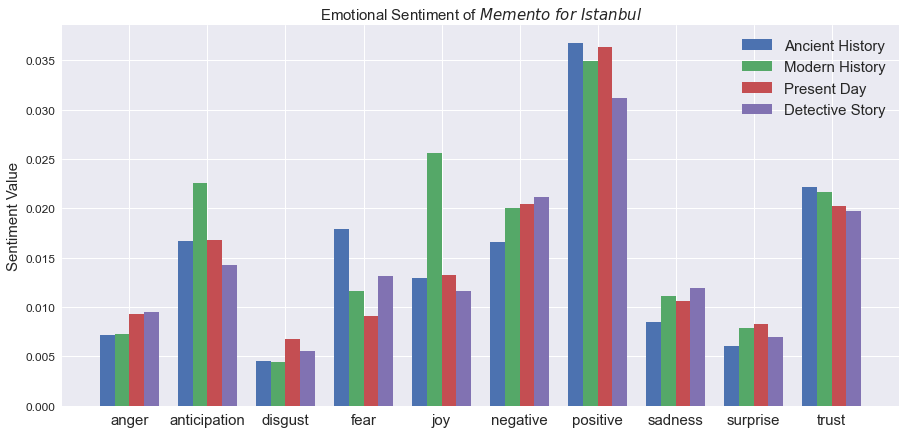

In [57]:
N = 10
ancient = df_ave.loc['Ancient History'][['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']]
modern = df_ave.loc['Modern History'][['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']]
present = df_ave.loc['Present Day'][['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']]
detective = df_ave.loc['Detective Story'][['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']]

ind = np.arange(N)  # the x locations for the groups
width = 0.1875       # the width of the bars

fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, ancient, width)
rects2 = ax.bar(ind+width, modern, width)
rects3 = ax.bar(ind+2*width, present, width)
rects4 = ax.bar(ind+3*width, detective, width)

ax.set_ylabel('Sentiment Value', fontsize=15)
ax.set_title('Emotional Sentiment of $Memento\ for\ Istanbul$', fontsize=15)
ax.set_xticks(ind + width*1.5)
ax.tick_params(labelsize=12)
ax.set_xticklabels(['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust'], fontsize=15)

ax.legend((rects1[0], rects2[0], rects3[0], rects4[0]), ('Ancient History', 'Modern History', 'Present Day', 'Detective Story'), fontsize=15)

plt.show()

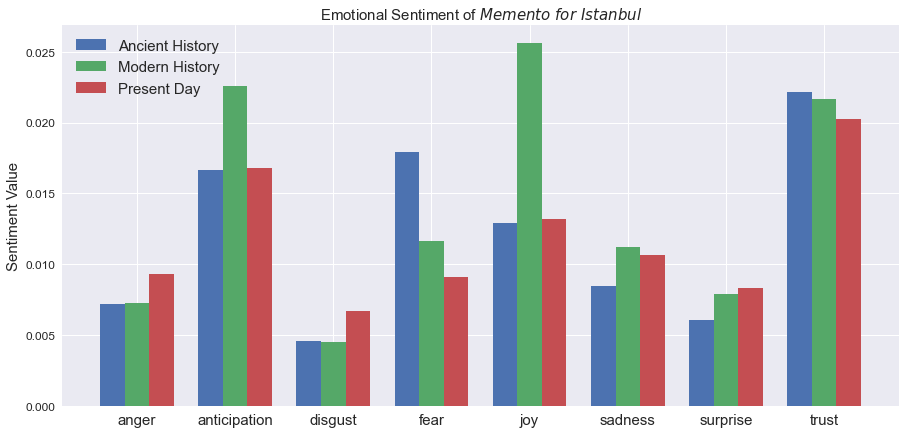

In [58]:
emotions = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']
N = len(emotions)

ancient = df_ave.loc['Ancient History'][emotions]
modern = df_ave.loc['Modern History'][emotions]
present = df_ave.loc['Present Day'][emotions]

ind = np.arange(N)  # the x locations for the groups
width = 0.25       # the width of the bars

fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, ancient, width)
rects2 = ax.bar(ind+width, modern, width)
rects3 = ax.bar(ind+2*width, present, width)

ax.set_ylabel('Sentiment Value', fontsize=15)
ax.set_title('Emotional Sentiment of $Memento\ for\ Istanbul$', fontsize=15)
ax.set_xticks(ind + width)
ax.tick_params(labelsize=12)
ax.set_xticklabels(emotions, fontsize=15)

ax.legend((rects1[0], rects2[0], rects3[0]), ('Ancient History', 'Modern History', 'Present Day'), fontsize=15)

plt.show()

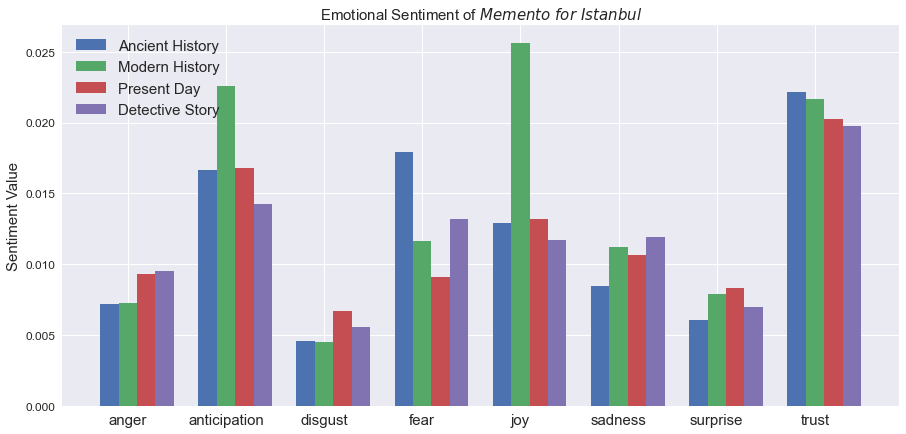

In [59]:
emotions = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']
N = len(emotions)

ancient = df_ave.loc['Ancient History'][emotions]
modern = df_ave.loc['Modern History'][emotions]
present = df_ave.loc['Present Day'][emotions]
detective = df_ave.loc['Detective Story'][emotions]

ind = np.arange(N)  # the x locations for the groups
width = 0.1875       # the width of the bars

fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, ancient, width)
rects2 = ax.bar(ind+width, modern, width)
rects3 = ax.bar(ind+2*width, present, width)
rects4 = ax.bar(ind+3*width, detective, width)

ax.set_ylabel('Sentiment Value', fontsize=15)
ax.set_title('Emotional Sentiment of $Memento\ for\ Istanbul$', fontsize=15)
ax.set_xticks(ind + width)
ax.tick_params(labelsize=12)
ax.set_xticklabels(emotions, fontsize=15)

ax.legend((rects1[0], rects2[0], rects3[0], rects4[0]), ('Ancient History', 'Modern History', 'Present Day', 'Detective Story'), fontsize=15)

plt.show()

# LDA

In [60]:
import operator
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# nltk for lemmatization
from nltk.stem import WordNetLemmatizer 

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [61]:
data = [section[2].replace('\n', ' ') for section in novel]

In [62]:
text_df = df.groupby('period')['text'].apply(lambda x: ','.join(x)).reset_index()
data = text_df['text'].tolist()
# text_df

In [63]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [64]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [65]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts):
    texts_out = []
    for sent in texts:
        texts_out.append([lemmatizer.lemmatize(word) for word in sent])
    return texts_out

In [66]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

lemmatizer = WordNetLemmatizer() 

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams)

In [67]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [68]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [69]:
# Print the Keyword in the 20 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.001*"said" + 0.001*"one" + 0.001*"ali" + 0.001*"u" + 0.000*"two" + '
  '0.000*"would" + 0.000*"like" + 0.000*"around" + 0.000*"even" + 0.000*"eye"'),
 (1,
  '0.001*"said" + 0.001*"ali" + 0.001*"u" + 0.001*"one" + 0.000*"would" + '
  '0.000*"city" + 0.000*"like" + 0.000*"look" + 0.000*"time" + 0.000*"know"'),
 (2,
  '0.012*"city" + 0.011*"emperor" + 0.009*"one" + 0.008*"would" + '
  '0.006*"sultan" + 0.006*"god" + 0.006*"built" + 0.006*"mosque" + '
  '0.005*"constantine" + 0.005*"said"'),
 (3,
  '0.001*"said" + 0.001*"one" + 0.001*"u" + 0.000*"ali" + 0.000*"know" + '
  '0.000*"like" + 0.000*"would" + 0.000*"around" + 0.000*"time" + '
  '0.000*"could"'),
 (4,
  '0.001*"said" + 0.001*"ali" + 0.000*"would" + 0.000*"one" + 0.000*"u" + '
  '0.000*"back" + 0.000*"like" + 0.000*"city" + 0.000*"time" + 0.000*"way"'),
 (5,
  '0.001*"said" + 0.001*"like" + 0.001*"one" + 0.001*"ali" + 0.001*"u" + '
  '0.001*"know" + 0.001*"city" + 0.000*"even" + 0.000*"would" + '
  '0.000*"mosque"'),
 (6

In [70]:
# Compute Perplexity
print ('Perplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print ('Coherence Score: ', coherence_lda)

Perplexity:  -8.100313177598325
Coherence Score:  0.25945432034046195


In [71]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis)

In [72]:
mallet_path = r'C:\\mallet\\bin\\mallet.bat'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [73]:
# Show Topics
pprint(ldamallet.show_topics(num_topics=1000, formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('yezdan', 0.0379746835443038),
   ('idea', 0.0310330747243773),
   ('watching', 0.01837484687627603),
   ('throat', 0.01796651694569212),
   ('sit', 0.013883217639853002),
   ('moment', 0.01347488770926909),
   ('shoulder', 0.01347488770926909),
   ('chance', 0.012658227848101266),
   ('news', 0.012249897917517355),
   ('historical', 0.011433238056349531)]),
 (1,
  [('hand', 0.03263274336283186),
   ('taking', 0.025995575221238937),
   ('zeynep', 0.02267699115044248),
   ('human', 0.02101769911504425),
   ('whispered', 0.01991150442477876),
   ('next_victim', 0.016039823008849558),
   ('ahead', 0.012168141592920354),
   ('close', 0.011615044247787611),
   ('ago', 0.011615044247787611),
   ('restaurant', 0.011061946902654867)]),
 (2,
  [('men', 0.02926829268292683),
   ('order', 0.019887429643527205),
   ('arm', 0.019887429643527205),
   ('pointed', 0.019136960600375234),
   ('book', 0.018386491557223265),
   ('end', 0.01801125703564728),
   ('coin', 0.01575984990619137),
   ('

In [74]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print('Calculating {}-topic model'.format(num_topics))
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [75]:
# Can take a long time to run.
limit=75; start=2; step=2;
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=data_lemmatized,
                                                        start=start,
                                                        limit=limit,
                                                        step=step)

Calculating 2-topic model
Calculating 4-topic model
Calculating 6-topic model
Calculating 8-topic model
Calculating 10-topic model
Calculating 12-topic model
Calculating 14-topic model
Calculating 16-topic model
Calculating 18-topic model
Calculating 20-topic model
Calculating 22-topic model
Calculating 24-topic model
Calculating 26-topic model
Calculating 28-topic model
Calculating 30-topic model
Calculating 32-topic model
Calculating 34-topic model
Calculating 36-topic model
Calculating 38-topic model
Calculating 40-topic model
Calculating 42-topic model
Calculating 44-topic model
Calculating 46-topic model
Calculating 48-topic model
Calculating 50-topic model
Calculating 52-topic model
Calculating 54-topic model
Calculating 56-topic model
Calculating 58-topic model
Calculating 60-topic model
Calculating 62-topic model
Calculating 64-topic model
Calculating 66-topic model
Calculating 68-topic model
Calculating 70-topic model
Calculating 72-topic model
Calculating 74-topic model


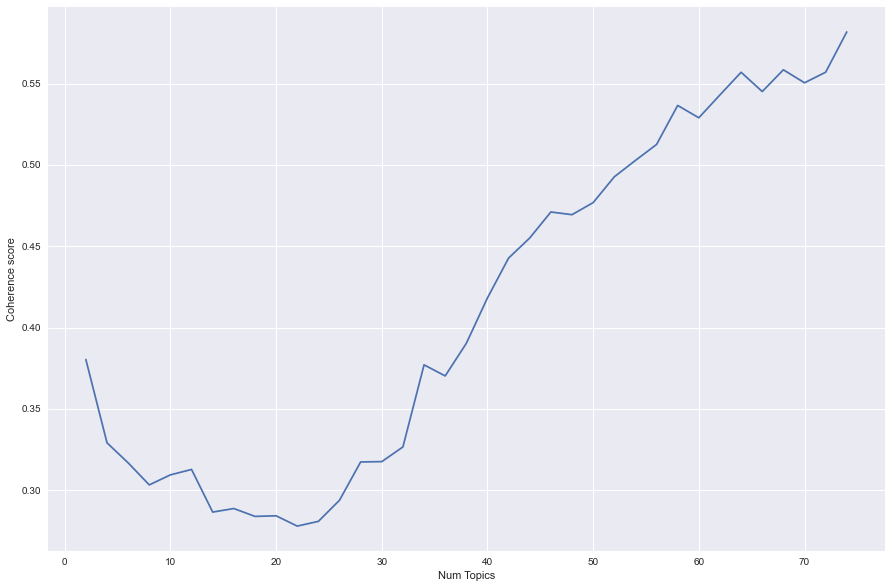

In [76]:
# Show graph
x = range(start, limit, step)
plt.figure(figsize=(15, 10))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
plt.show()

In [77]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 6))

Num Topics = 2  has Coherence Value of 0.3803
Num Topics = 4  has Coherence Value of 0.329061
Num Topics = 6  has Coherence Value of 0.316735
Num Topics = 8  has Coherence Value of 0.303176
Num Topics = 10  has Coherence Value of 0.309344
Num Topics = 12  has Coherence Value of 0.312678
Num Topics = 14  has Coherence Value of 0.286451
Num Topics = 16  has Coherence Value of 0.288641
Num Topics = 18  has Coherence Value of 0.283801
Num Topics = 20  has Coherence Value of 0.284163
Num Topics = 22  has Coherence Value of 0.277836
Num Topics = 24  has Coherence Value of 0.280735
Num Topics = 26  has Coherence Value of 0.293742
Num Topics = 28  has Coherence Value of 0.317286
Num Topics = 30  has Coherence Value of 0.317495
Num Topics = 32  has Coherence Value of 0.326524
Num Topics = 34  has Coherence Value of 0.377018
Num Topics = 36  has Coherence Value of 0.370217
Num Topics = 38  has Coherence Value of 0.390255
Num Topics = 40  has Coherence Value of 0.418197
Num Topics = 42  has Coher

In [78]:
# Select the model and print the topics
index, value = max(enumerate(coherence_values), key=operator.itemgetter(1))
index = 24
optimal_model = model_list[index]
model_topics = optimal_model.show_topics(num_topics=1000, formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(9,
  '0.120*"ali" + 0.078*"zeynep" + 0.050*"body" + 0.041*"thought" + '
  '0.032*"moment" + 0.031*"guy" + 0.022*"straight" + 0.022*"idea" + '
  '0.019*"leave" + 0.017*"replied"'),
 (5,
  '0.033*"evidence" + 0.026*"answer" + 0.026*"taking" + 0.026*"address" + '
  '0.024*"choice" + 0.024*"frame" + 0.024*"antique" + 0.020*"heading" + '
  '0.018*"fighting" + 0.018*"pure"'),
 (28,
  '0.018*"ship" + 0.018*"true" + 0.018*"united" + 0.014*"leaf" + '
  '0.014*"hospital" + 0.014*"guesthouse" + 0.014*"extended" + 0.014*"title" + '
  '0.014*"demand" + 0.011*"archway"'),
 (22,
  '0.089*"city" + 0.042*"built" + 0.039*"sultan" + 0.030*"ottoman" + '
  '0.023*"building" + 0.021*"day" + 0.019*"architect" + 0.019*"sea" + '
  '0.018*"time" + 0.015*"king"'),
 (4,
  '0.042*"view" + 0.035*"mist" + 0.026*"byzantine" + 0.026*"narrow" + '
  '0.021*"crumbling" + 0.019*"today" + 0.016*"dirt" + 0.016*"selam" + '
  '0.014*"filling" + 0.014*"flow"'),
 (34,
  '0.107*"killed" + 0.024*"shaking" + 0.023*"started" + 0.

In [79]:
optimal_model.show_topic(0,15)

[('god', 0.06288659793814433),
 ('constantine', 0.0577319587628866),
 ('order', 0.026804123711340205),
 ('hagia_sophia', 0.023195876288659795),
 ('constantinople', 0.023195876288659795),
 ('temple', 0.020103092783505156),
 ('began', 0.01907216494845361),
 ('brought', 0.018556701030927835),
 ('arm', 0.017010309278350514),
 ('number', 0.015979381443298968),
 ('allah', 0.015463917525773196),
 ('raised', 0.013917525773195877),
 ('men', 0.013917525773195877),
 ('state', 0.013402061855670102),
 ('power', 0.01288659793814433)]

In [80]:
for topic in sorted(optimal_model.show_topics(num_topics=1000, num_words=10, formatted=False), key=lambda x: x[0]):
    print('Topic {}: {}'.format(topic[0], [item[0] for item in topic[1]]))

Topic 0: ['god', 'constantine', 'order', 'hagia_sophia', 'constantinople', 'temple', 'began', 'brought', 'arm', 'number']
Topic 1: ['yekta', 'victim', 'work', 'adem_yezdan', 'sir', 'nevzat', 'good', 'friend', 'found', 'yezdan']
Topic 2: ['sultan_mehmed', 'great', 'construction', 'stood', 'conqueror', 'land', 'entrance', 'centre', 'dream', 'back']
Topic 3: ['occurred', 'photograph', 'trouble', 'affection', 'shirt', 'alright', 'applied', 'married', 'clean', 'tall']
Topic 4: ['view', 'mist', 'byzantine', 'narrow', 'crumbling', 'today', 'dirt', 'selam', 'filling', 'flow']
Topic 5: ['evidence', 'answer', 'taking', 'address', 'choice', 'frame', 'antique', 'heading', 'fighting', 'pure']
Topic 6: ['asked', 'word', 'light', 'made', 'night', 'mind', 'fact', 'history', 'open', 'chief']
Topic 7: ['street', 'house', 'church', 'ground', 'istanbul', 'child', 'tomb', 'gate', 'tree', 'water']
Topic 8: ['involved', 'felt', 'interest', 'statement', 'company', 'share', 'mr_karaman', 'possibility', 'white_

In [81]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([i, 'First', topic_num, round(prop_topic,4), topic_keywords]), ignore_index=True)
            elif j == 1:  # => second-highest topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([i, 'Second', topic_num, round(prop_topic,4), topic_keywords]), ignore_index=True)
            elif j == 2:  # => third-highest topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([i, 'Third', topic_num, round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    sent_topics_df.columns = ['Document_No', 'Topic_Rank', 'Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Text']
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.copy()
df_dominant_topic['Document_No'] = df_dominant_topic['Document_No'].astype(int)
df_dominant_topic['Dominant_Topic'] = df_dominant_topic['Dominant_Topic'].astype(int)
df_dominant_topic.columns = ['Document_No', 'Topic_Rank', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic[['Document_No', 'Topic_Rank',  'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords']]

,Document_No,Topic_Rank,Dominant_Topic,Topic_Perc_Contrib,Keywords
0,0,First,22,0.1853,"city, built, sultan, ottoman, building, day, a..."
1,0,Second,0,0.1100,"god, constantine, order, hagia_sophia, constan..."
2,0,Third,23,0.1079,"emperor, deity, justinian, rome, empire, ruler..."
3,1,First,45,0.0932,"eye, coin, ali, face, thing, life, told, murde..."
4,1,Second,1,0.0822,"yekta, victim, work, adem_yezdan, sir, nevzat,..."
5,1,Third,6,0.0695,"asked, word, light, made, night, mind, fact, h..."
6,2,First,7,0.2173,"street, house, church, ground, istanbul, child..."
7,2,Second,13,0.1783,"uncle, prayer, kid, memory, sultan_selim, aunt..."
8,2,Third,48,0.1161,"back, day, place, house, home, happened, room,..."
9,3,First,36,0.1438,"mosque, wall, palace, column, world, people, r..."


In [82]:
docs = text_df['period'].unique().tolist()

for idx, row in df_dominant_topic.iterrows():
    print('{}, {} topic : {}'.format(docs[row['Document_No']], row['Topic_Rank'], row['Keywords'].split(', ')[:10]))

Ancient History, First topic : ['city', 'built', 'sultan', 'ottoman', 'building', 'day', 'architect', 'sea', 'time', 'king']
Ancient History, Second topic : ['god', 'constantine', 'order', 'hagia_sophia', 'constantinople', 'temple', 'began', 'brought', 'arm', 'number']
Ancient History, Third topic : ['emperor', 'deity', 'justinian', 'rome', 'empire', 'ruler', 'victory', 'earth', 'hippodrome', 'soldier']
Detective Story, First topic : ['eye', 'coin', 'ali', 'face', 'thing', 'life', 'told', 'murder', 'make', 'wanted']
Detective Story, Second topic : ['yekta', 'victim', 'work', 'adem_yezdan', 'sir', 'nevzat', 'good', 'friend', 'found', 'yezdan']
Detective Story, Third topic : ['asked', 'word', 'light', 'made', 'night', 'mind', 'fact', 'history', 'open', 'chief']
Modern History, First topic : ['street', 'house', 'church', 'ground', 'istanbul', 'child', 'tomb', 'gate', 'tree', 'water']
Modern History, Second topic : ['uncle', 'prayer', 'kid', 'memory', 'sultan_selim', 'aunt', 'suleymaniye',

In [83]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Document_No', 'Topic_Rank', 'Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet[['Topic_Num', "Topic_Perc_Contrib", "Keywords"]]

,Topic_Num,Topic_Perc_Contrib,Keywords
0,0.0,0.1100,"god, constantine, order, hagia_sophia, constan..."
1,1.0,0.0822,"yekta, victim, work, adem_yezdan, sir, nevzat,..."
2,6.0,0.0695,"asked, word, light, made, night, mind, fact, h..."
3,7.0,0.2173,"street, house, church, ground, istanbul, child..."
4,13.0,0.1783,"uncle, prayer, kid, memory, sultan_selim, aunt..."
5,22.0,0.1853,"city, built, sultan, ottoman, building, day, a..."
6,23.0,0.1079,"emperor, deity, justinian, rome, empire, ruler..."
7,32.0,0.0893,"felt, istanbul, past, road, passed, sense, apa..."
8,36.0,0.1438,"mosque, wall, palace, column, world, people, r..."
9,45.0,0.0932,"eye, coin, ali, face, thing, life, told, murde..."


In [84]:
# for idx, row in sent_topics_sorteddf_mallet.iterrows():
#     print('Topic number {}'.format(int(row['Topic_Num'])))
#     print('Keywords: {}'.format(row['Keywords']))
#     print()
#     print(row['Text'])
#     print()

In [85]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts().reset_index(drop=True)

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4).reset_index(drop=True)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf_mallet[['Topic_Num', 'Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Percent_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Percent_Documents
0,0.0,"god, constantine, order, hagia_sophia, constan...",2,0.1667
1,1.0,"yekta, victim, work, adem_yezdan, sir, nevzat,...",1,0.0833
2,6.0,"asked, word, light, made, night, mind, fact, h...",1,0.0833
3,7.0,"street, house, church, ground, istanbul, child...",1,0.0833
4,13.0,"uncle, prayer, kid, memory, sultan_selim, aunt...",1,0.0833
5,22.0,"city, built, sultan, ottoman, building, day, a...",1,0.0833
6,23.0,"emperor, deity, justinian, rome, empire, ruler...",1,0.0833
7,32.0,"felt, istanbul, past, road, passed, sense, apa...",1,0.0833
8,36.0,"mosque, wall, palace, column, world, people, r...",1,0.0833
9,45.0,"eye, coin, ali, face, thing, life, told, murde...",1,0.0833


In [86]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    pd.set_option('display.max_colwidth', -1)
    display(df_dominant_topics)

<ipython-input-86-ac90e0fd5d9d>:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,Dominant_Topic,Topic_Keywords,Num_Documents,Percent_Documents
0,0.0,"god, constantine, order, hagia_sophia, constantinople, temple, began, brought, arm, number",2,0.1667
1,1.0,"yekta, victim, work, adem_yezdan, sir, nevzat, good, friend, found, yezdan",1,0.0833
2,6.0,"asked, word, light, made, night, mind, fact, history, open, chief",1,0.0833
3,7.0,"street, house, church, ground, istanbul, child, tomb, gate, tree, water",1,0.0833
4,13.0,"uncle, prayer, kid, memory, sultan_selim, aunt, suleymaniye, motif, shout, childhood",1,0.0833
5,22.0,"city, built, sultan, ottoman, building, day, architect, sea, time, king",1,0.0833
6,23.0,"emperor, deity, justinian, rome, empire, ruler, victory, earth, hippodrome, soldier",1,0.0833
7,32.0,"felt, istanbul, past, road, passed, sense, apartment, girl, turkish, round",1,0.0833
8,36.0,"mosque, wall, palace, column, world, people, roman, stone, ancient, thousand",1,0.0833
9,45.0,"eye, coin, ali, face, thing, life, told, murder, make, wanted",1,0.0833
